# Enron Fruad 项目概述
### 在此项目中，你将扮演侦探，运用你的机器学习技能构建一个算法，通过公开的安然财务和邮件数据集，找出有欺诈嫌疑的安然雇员。

In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib notebook
from scipy.stats import trim_mean
import seaborn as sns
import numpy as np
import pandas as pd
import sys
import pickle

from __future__ import division
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_curve, precision_score, recall_score
from sklearn.metrics import classification_report, mean_absolute_error, r2_score, mean_squared_error
from sklearn.decomposition import PCA, FastICA, KernelPCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from feature_format import featureFormat
from feature_format import targetFeatureSplit

data_dict = pickle.load(open("final_project_dataset.pkl", "r") )

/Users/Joel/anaconda/envs/py2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [19]:
data_dict

{'ALLEN PHILLIP K': {'bonus': 4175000,
  'deferral_payments': 2869717,
  'deferred_income': -3081055,
  'director_fees': 'NaN',
  'email_address': 'phillip.allen@enron.com',
  'exercised_stock_options': 1729541,
  'expenses': 13868,
  'from_messages': 2195,
  'from_poi_to_this_person': 47,
  'from_this_person_to_poi': 65,
  'loan_advances': 'NaN',
  'long_term_incentive': 304805,
  'other': 152,
  'poi': False,
  'restricted_stock': 126027,
  'restricted_stock_deferred': -126027,
  'salary': 201955,
  'shared_receipt_with_poi': 1407,
  'to_messages': 2902,
  'total_payments': 4484442,
  'total_stock_value': 1729541},
 'BADUM JAMES P': {'bonus': 'NaN',
  'deferral_payments': 178980,
  'deferred_income': 'NaN',
  'director_fees': 'NaN',
  'email_address': 'NaN',
  'exercised_stock_options': 257817,
  'expenses': 3486,
  'from_messages': 'NaN',
  'from_poi_to_this_person': 'NaN',
  'from_this_person_to_poi': 'NaN',
  'loan_advances': 'NaN',
  'long_term_incentive': 'NaN',
  'other': 'NaN'

## 数据探索
- 数据点总数
- 类之间的分配（POI/非 POI）
- 使用的特征数量
- 是否有哪些特征有很多缺失值？等。

In [2]:
df = pd.DataFrame(data_dict).T
df.head()

bonus deferral_payments deferred_income director_fees  \
ALLEN PHILLIP K     4175000           2869717        -3081055           NaN   
BADUM JAMES P           NaN            178980             NaN           NaN   
BANNANTINE JAMES M      NaN               NaN           -5104           NaN   
BAXTER JOHN C       1200000           1295738        -1386055           NaN   
BAY FRANKLIN R       400000            260455         -201641           NaN   

                                 email_address exercised_stock_options  \
ALLEN PHILLIP K        phillip.allen@enron.com                 1729541   
BADUM JAMES P                              NaN                  257817   
BANNANTINE JAMES M  james.bannantine@enron.com                 4046157   
BAXTER JOHN C                              NaN                 6680544   
BAY FRANKLIN R             frank.bay@enron.com                     NaN   

                   expenses from_messages from_poi_to_this_person  \
ALLEN PHILLIP K       13868          2195                      47   
BADUM JAMES P          3486           NaN                     NaN   
BANNANTINE JAMES M    56301            29                      39   
BAXTER JOHN C         11200           NaN                     NaN   
BAY FRANKLIN R       129142           NaN                     NaN   

                   from_this_person_to_poi        ...         \
ALLEN PHILLIP K                         65        ...          
BADUM JAMES P                          NaN        ...          
BANNANTINE JAMES M                       0        ...          
BAXTER JOHN C                          NaN        ...          
BAY FRANKLIN R                         NaN        ...          

                   long_term_incentive    other    poi restricted_stock  \
ALLEN PHILLIP K                 304805      152  False           126027   
BADUM JAMES P                      NaN      NaN  False              NaN   
BANNANTINE JAMES M                 NaN   864523  False          1757552   
BAXTER JOHN C                  1586055  2660303  False          3942714   
BAY FRANKLIN R                     NaN       69  False           145796   

                   restricted_stock_deferred  salary shared_receipt_with_poi  \
ALLEN PHILLIP K                      -126027  201955                    1407   
BADUM JAMES P                            NaN     NaN                     NaN   
BANNANTINE JAMES M                   -560222     477                     465   
BAXTER JOHN C                            NaN  267102                     NaN   
BAY FRANKLIN R                        -82782  239671                     NaN   

                   to_messages total_payments total_stock_value  
ALLEN PHILLIP K           2902        4484442           1729541  
BADUM JAMES P              NaN         182466            257817  
BANNANTINE JAMES M         566         916197           5243487  
BAXTER JOHN C              NaN        5634343          10623258  
BAY FRANKLIN R             NaN         827696             63014  

[5 rows x 21 columns]

### 数据点总数
- 146嫌疑犯，21個特征，包含「财务特征」，「邮件特征」，「POI 标签」

In [4]:
df.shape

(146, 21)

### 类之间的分配

- 「财务特征」為 Numerical

- 「邮件特征」為 Numerical / Text

- 「POI标签」為 Categorical


In [3]:
df.dtypes

bonus                        object
deferral_payments            object
deferred_income              object
director_fees                object
email_address                object
exercised_stock_options      object
expenses                     object
from_messages                object
from_poi_to_this_person      object
from_this_person_to_poi      object
loan_advances                object
long_term_incentive          object
other                        object
poi                          object
restricted_stock             object
restricted_stock_deferred    object
salary                       object
shared_receipt_with_poi      object
to_messages                  object
total_payments               object
total_stock_value            object
dtype: object

In [83]:
df.columns.values
flt_col = ['bonus', 'deferral_payments', 'deferred_income', 'director_fees',
       'exercised_stock_options', 'expenses',
       'from_messages', 'from_poi_to_this_person',
       'from_this_person_to_poi', 'loan_advances', 'long_term_incentive',
       'other', 'restricted_stock', 'restricted_stock_deferred',
       'salary', 'shared_receipt_with_poi', 'to_messages',
       'total_payments', 'total_stock_value']

### 把「email_address」，「poi」以外做轉換型態

In [4]:
df[flt_col] = df[flt_col].apply(pd.to_numeric, errors='coerce')
df.dtypes

bonus                        float64
deferral_payments            float64
deferred_income              float64
director_fees                float64
email_address                 object
exercised_stock_options      float64
expenses                     float64
from_messages                float64
from_poi_to_this_person      float64
from_this_person_to_poi      float64
loan_advances                float64
long_term_incentive          float64
other                        float64
poi                           object
restricted_stock             float64
restricted_stock_deferred    float64
salary                       float64
shared_receipt_with_poi      float64
to_messages                  float64
total_payments               float64
total_stock_value            float64
dtype: object

### 使用的特征数量
### 是否有哪些特征有很多缺失值？等

In [5]:
df_miss = df.select_dtypes(include = ['float64', 'int64'])#.iloc[:, 1:]
total = df_miss.isnull().sum().sort_values(ascending=False)
pd.DataFrame(total, columns=['Missing Values'])

Missing Values
loan_advances                         142
director_fees                         129
restricted_stock_deferred             128
deferral_payments                     107
deferred_income                        97
long_term_incentive                    80
bonus                                  64
from_this_person_to_poi                60
from_poi_to_this_person                60
from_messages                          60
shared_receipt_with_poi                60
to_messages                            60
other                                  53
expenses                               51
salary                                 51
exercised_stock_options                44
restricted_stock                       36
total_payments                         21
total_stock_value                      20

### 遺失值過多的Feature，丟失過多數據，不適用填充值方式取代
- loan_advances	142
- director_fees	129
- restricted_stock_deferred	128
- deferral_payments	107
- deferred_income	97
- long_term_incentive	80

### 遺失值比較少的Feature
- exercised_stock_options	44
- restricted_stock	36
- total_payments	21
- total_stock_value	20


#### 針對遺失值較少的處理方式
- 透過相關性，檢查是跟否存在規律

<IPython.core.display.Javascript object>


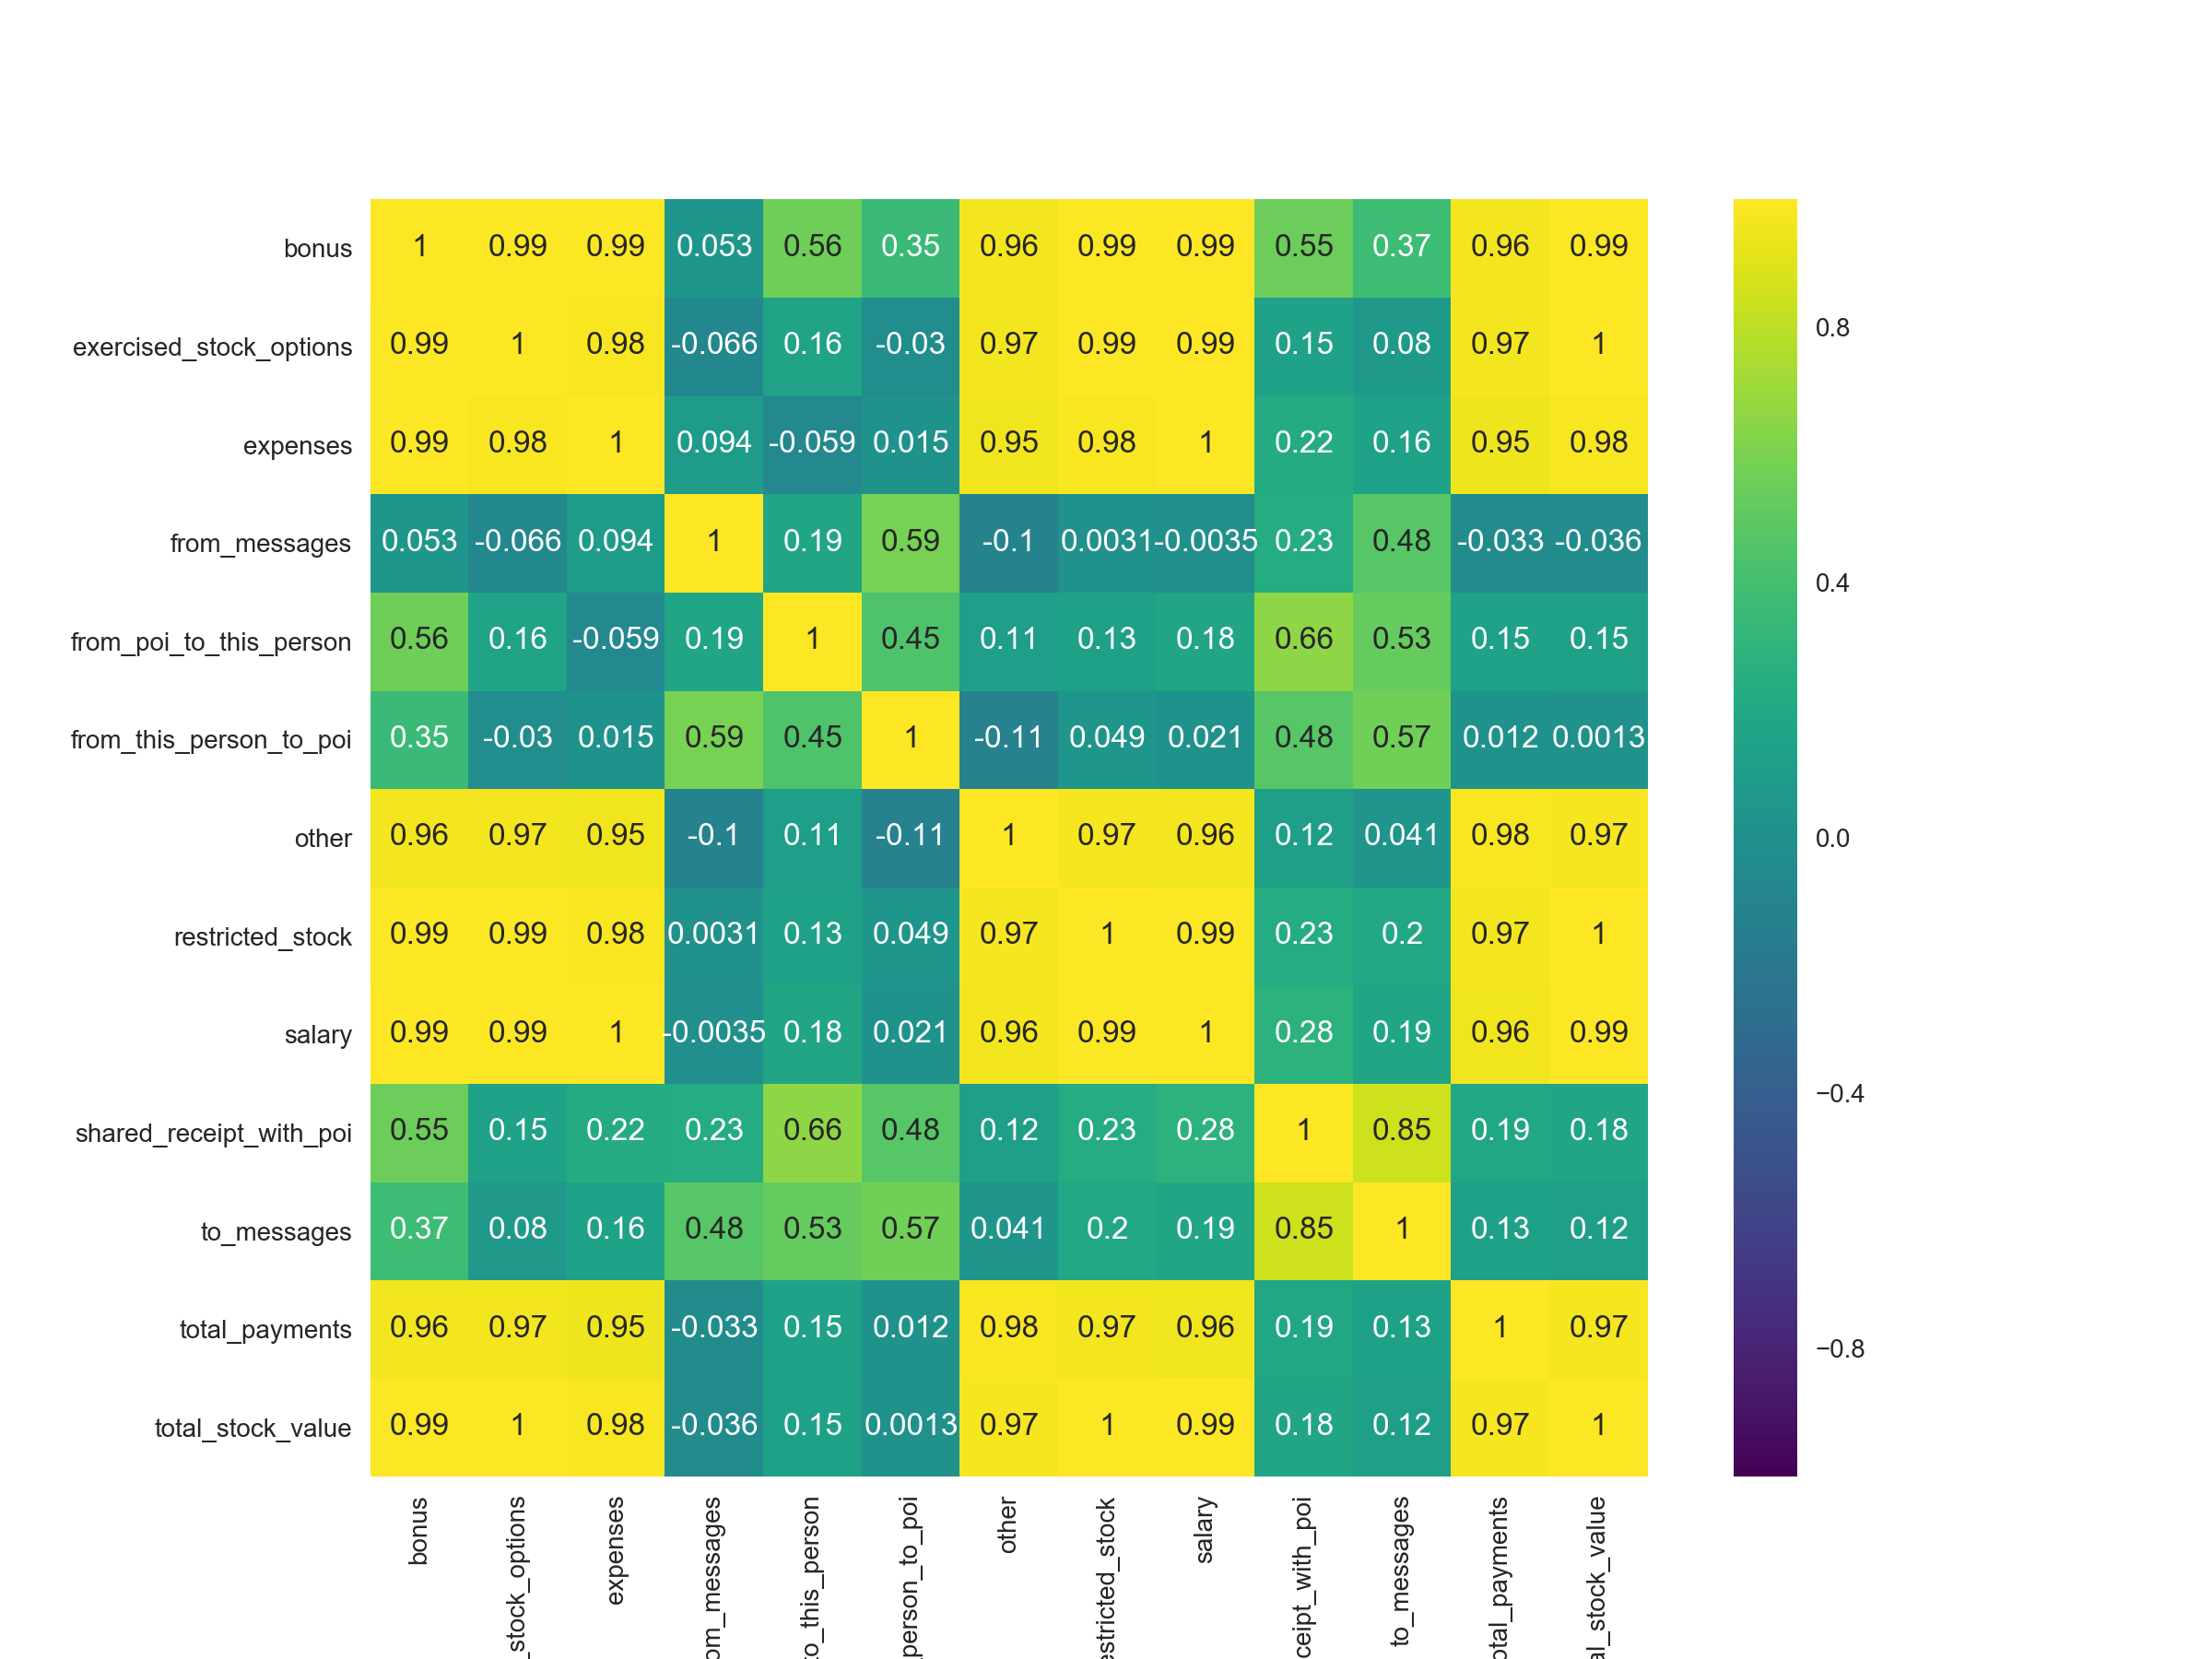

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5]), <a list of 13 Text yticklabel objects>)

In [6]:
dropf = ['loan_advances','director_fees','restricted_stock_deferred',
         'deferral_payments','deferred_income','long_term_incentive']

# 移除遺失過多的feature
df_less = df.drop(dropf ,axis=1).copy()

corrmat = df_less.select_dtypes(include = ['float64', 'int64']).corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, annot=True, cmap='viridis', square=True);
plt.xticks(rotation=90) 
plt.yticks(rotation=0) 

高度相關性的特徵值
**bonus, exercised_stock_options, expense, other, restricted_stock, salary, total_payments, total_stock_value**

### 處理遺失值


In [10]:
df.describe()

bonus  deferral_payments  deferred_income  director_fees  \
count  8.200000e+01       3.900000e+01     4.900000e+01   1.700000e+01   
mean   2.374235e+06       1.642674e+06    -1.140475e+06   1.668049e+05   
std    1.071333e+07       5.161930e+06     4.025406e+06   3.198914e+05   
min    7.000000e+04      -1.025000e+05    -2.799289e+07   3.285000e+03   
25%    4.312500e+05       8.157300e+04    -6.948620e+05   9.878400e+04   
50%    7.693750e+05       2.274490e+05    -1.597920e+05   1.085790e+05   
75%    1.200000e+06       1.002672e+06    -3.834600e+04   1.137840e+05   
max    9.734362e+07       3.208340e+07    -8.330000e+02   1.398517e+06   

       exercised_stock_options      expenses  from_messages  \
count             1.020000e+02  9.500000e+01      86.000000   
mean              5.987054e+06  1.087289e+05     608.790698   
std               3.106201e+07  5.335348e+05    1841.033949   
min               3.285000e+03  1.480000e+02      12.000000   
25%               5.278862e+05  2.261400e+04      22.750000   
50%               1.310814e+06  4.695000e+04      41.000000   
75%               2.547724e+06  7.995250e+04     145.500000   
max               3.117640e+08  5.235198e+06   14368.000000   

       from_poi_to_this_person  from_this_person_to_poi  loan_advances  \
count                86.000000                86.000000   4.000000e+00   
mean                 64.895349                41.232558   4.196250e+07   
std                  86.979244               100.073111   4.708321e+07   
min                   0.000000                 0.000000   4.000000e+05   
25%                  10.000000                 1.000000   1.600000e+06   
50%                  35.000000                 8.000000   4.176250e+07   
75%                  72.250000                24.750000   8.212500e+07   
max                 528.000000               609.000000   8.392500e+07   

       long_term_incentive         other  restricted_stock  \
count         6.600000e+01  9.300000e+01      1.100000e+02   
mean          1.470361e+06  9.190650e+05      2.321741e+06   
std           5.942759e+06  4.589253e+06      1.251828e+07   
min           6.922300e+04  2.000000e+00     -2.604490e+06   
25%           2.812500e+05  1.215000e+03      2.540180e+05   
50%           4.420350e+05  5.238200e+04      4.517400e+05   
75%           9.386720e+05  3.620960e+05      1.002370e+06   
max           4.852193e+07  4.266759e+07      1.303223e+08   

       restricted_stock_deferred        salary  shared_receipt_with_poi  \
count               1.800000e+01  9.500000e+01                86.000000   
mean                1.664106e+05  5.621943e+05              1176.465116   
std                 4.201494e+06  2.716369e+06              1178.317641   
min                -7.576788e+06  4.770000e+02                 2.000000   
25%                -3.896218e+05  2.118160e+05               249.750000   
50%                -1.469750e+05  2.599960e+05               740.500000   
75%                -7.500975e+04  3.121170e+05              1888.250000   
max                 1.545629e+07  2.670423e+07              5521.000000   

        to_messages  total_payments  total_stock_value  
count     86.000000    1.250000e+02       1.260000e+02  
mean    2073.860465    5.081526e+06       6.773957e+06  
std     2582.700981    2.906172e+07       3.895777e+07  
min       57.000000    1.480000e+02      -4.409300e+04  
25%      541.250000    3.944750e+05       4.945102e+05  
50%     1211.000000    1.101393e+06       1.102872e+06  
75%     2634.750000    2.093263e+06       2.949847e+06  
max    15149.000000    3.098866e+08       4.345095e+08

### 處理遺失值，把NaN全部改成0
- Std過大，不適合用interpolate內插法
- 樣本過少，不適合插入中位數，或是平均值

In [3]:
df = df.fillna(0)
df.head()

bonus deferral_payments deferred_income director_fees  \
ALLEN PHILLIP K     4175000           2869717        -3081055           NaN   
BADUM JAMES P           NaN            178980             NaN           NaN   
BANNANTINE JAMES M      NaN               NaN           -5104           NaN   
BAXTER JOHN C       1200000           1295738        -1386055           NaN   
BAY FRANKLIN R       400000            260455         -201641           NaN   

                                 email_address exercised_stock_options  \
ALLEN PHILLIP K        phillip.allen@enron.com                 1729541   
BADUM JAMES P                              NaN                  257817   
BANNANTINE JAMES M  james.bannantine@enron.com                 4046157   
BAXTER JOHN C                              NaN                 6680544   
BAY FRANKLIN R             frank.bay@enron.com                     NaN   

                   expenses from_messages from_poi_to_this_person  \
ALLEN PHILLIP K       13868          2195                      47   
BADUM JAMES P          3486           NaN                     NaN   
BANNANTINE JAMES M    56301            29                      39   
BAXTER JOHN C         11200           NaN                     NaN   
BAY FRANKLIN R       129142           NaN                     NaN   

                   from_this_person_to_poi        ...         \
ALLEN PHILLIP K                         65        ...          
BADUM JAMES P                          NaN        ...          
BANNANTINE JAMES M                       0        ...          
BAXTER JOHN C                          NaN        ...          
BAY FRANKLIN R                         NaN        ...          

                   long_term_incentive    other    poi  restricted_stock  \
ALLEN PHILLIP K                 304805      152  False            126027   
BADUM JAMES P                      NaN      NaN  False               NaN   
BANNANTINE JAMES M                 NaN   864523  False           1757552   
BAXTER JOHN C                  1586055  2660303  False           3942714   
BAY FRANKLIN R                     NaN       69  False            145796   

                   restricted_stock_deferred  salary shared_receipt_with_poi  \
ALLEN PHILLIP K                      -126027  201955                    1407   
BADUM JAMES P                            NaN     NaN                     NaN   
BANNANTINE JAMES M                   -560222     477                     465   
BAXTER JOHN C                            NaN  267102                     NaN   
BAY FRANKLIN R                        -82782  239671                     NaN   

                   to_messages total_payments total_stock_value  
ALLEN PHILLIP K           2902        4484442           1729541  
BADUM JAMES P              NaN         182466            257817  
BANNANTINE JAMES M         566         916197           5243487  
BAXTER JOHN C              NaN        5634343          10623258  
BAY FRANKLIN R             NaN         827696             63014  

[5 rows x 21 columns]

In [4]:
for items in data_dict:
    for i in data_dict[items]:
        if data_dict[items][i] == "NaN":
            data_dict[items][i] = 0
dft = pd.DataFrame(data_dict)
dft.isnull().any().any()

False

### Email Address 遺失值處理
- 邮件特征得知，最高訊息含量的，會跟poi有關，郵箱地址沒有什麼訊息含量

In [5]:
df = df.drop('email_address', axis = 1)

In [6]:
for individual in data_dict:
    del data_dict[individual]['email_address']
data_dict

{'ALLEN PHILLIP K': {'bonus': 4175000,
  'deferral_payments': 2869717,
  'deferred_income': -3081055,
  'director_fees': 0,
  'exercised_stock_options': 1729541,
  'expenses': 13868,
  'from_messages': 2195,
  'from_poi_to_this_person': 47,
  'from_this_person_to_poi': 65,
  'loan_advances': 0,
  'long_term_incentive': 304805,
  'other': 152,
  'poi': False,
  'restricted_stock': 126027,
  'restricted_stock_deferred': -126027,
  'salary': 201955,
  'shared_receipt_with_poi': 1407,
  'to_messages': 2902,
  'total_payments': 4484442,
  'total_stock_value': 1729541},
 'BADUM JAMES P': {'bonus': 0,
  'deferral_payments': 178980,
  'deferred_income': 0,
  'director_fees': 0,
  'exercised_stock_options': 257817,
  'expenses': 3486,
  'from_messages': 0,
  'from_poi_to_this_person': 0,
  'from_this_person_to_poi': 0,
  'loan_advances': 0,
  'long_term_incentive': 0,
  'other': 0,
  'poi': False,
  'restricted_stock': 0,
  'restricted_stock_deferred': 0,
  'salary': 0,
  'shared_receipt_with_p

### 特征Poi處理
- poi 總數**18**人
- 沒有存在遺失值
- 進行LabelEncoder編碼處理

In [22]:
len(df[df['poi']==True]) ## Number of poi

18

In [7]:
label = LabelEncoder()
df['poi'] = label.fit_transform(df['poi'])
df['poi'].tail()

WINOKUR JR. HERBERT S    0
WODRASKA JOHN            0
WROBEL BRUCE             0
YEAGER F SCOTT           1
YEAP SOON                0
Name: poi, dtype: int64

In [8]:
for indiv in data_dict:
    for i in data_dict[indiv]:
        if i == 'poi':
            if data_dict[indiv][i] == True:
                data_dict[indiv][i] = 1
            else:
                data_dict[indiv][i] = 0
data_dict

{'ALLEN PHILLIP K': {'bonus': 4175000,
  'deferral_payments': 2869717,
  'deferred_income': -3081055,
  'director_fees': 0,
  'exercised_stock_options': 1729541,
  'expenses': 13868,
  'from_messages': 2195,
  'from_poi_to_this_person': 47,
  'from_this_person_to_poi': 65,
  'loan_advances': 0,
  'long_term_incentive': 304805,
  'other': 152,
  'poi': 0,
  'restricted_stock': 126027,
  'restricted_stock_deferred': -126027,
  'salary': 201955,
  'shared_receipt_with_poi': 1407,
  'to_messages': 2902,
  'total_payments': 4484442,
  'total_stock_value': 1729541},
 'BADUM JAMES P': {'bonus': 0,
  'deferral_payments': 178980,
  'deferred_income': 0,
  'director_fees': 0,
  'exercised_stock_options': 257817,
  'expenses': 3486,
  'from_messages': 0,
  'from_poi_to_this_person': 0,
  'from_this_person_to_poi': 0,
  'loan_advances': 0,
  'long_term_incentive': 0,
  'other': 0,
  'poi': 0,
  'restricted_stock': 0,
  'restricted_stock_deferred': 0,
  'salary': 0,
  'shared_receipt_with_poi': 0,


## 异常值调查

### 找出 outlier
- 下圖得知，Salary超過2.5億，極端異常值

<IPython.core.display.Javascript object>


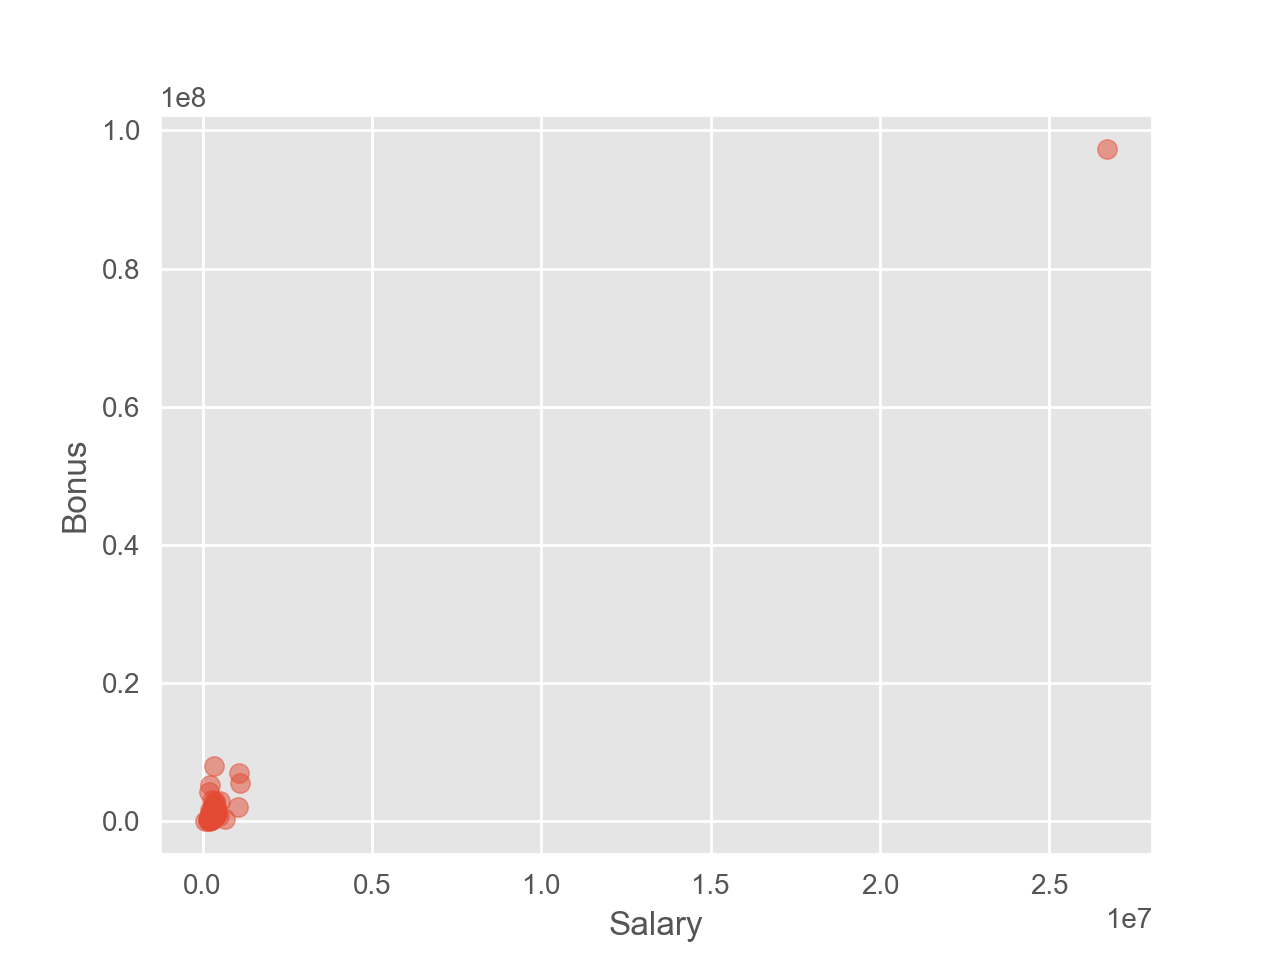

In [14]:
plt.scatter(df['salary'], df['bonus'], alpha=.5, edgecolors='face')
plt.xlabel("Salary")
plt.ylabel("Bonus")
plt.show()

In [14]:
df[df['salary']>2.5e7]

bonus  deferral_payments  deferred_income  director_fees  \
TOTAL  97343619.0         32083396.0      -27992891.0      1398517.0   

      email_address  exercised_stock_options   expenses  from_messages  \
TOTAL           NaN              311764000.0  5235198.0            0.0   

       from_poi_to_this_person  from_this_person_to_poi        ...          \
TOTAL                      0.0                      0.0        ...           

       long_term_incentive       other  poi  restricted_stock  \
TOTAL           48521928.0  42667589.0    0       130322299.0   

       restricted_stock_deferred      salary  shared_receipt_with_poi  \
TOTAL                 -7576788.0  26704229.0                      0.0   

       to_messages  total_payments  total_stock_value  
TOTAL          0.0     309886585.0        434509511.0  

[1 rows x 21 columns]

### Total 不是個體單位，所以移除 「TOTAL」

In [9]:
df.drop('TOTAL', axis = 0, inplace = True)

In [10]:
del data_dict['TOTAL']

### 從Scatter 查看分佈，依然有少數的異常

<IPython.core.display.Javascript object>


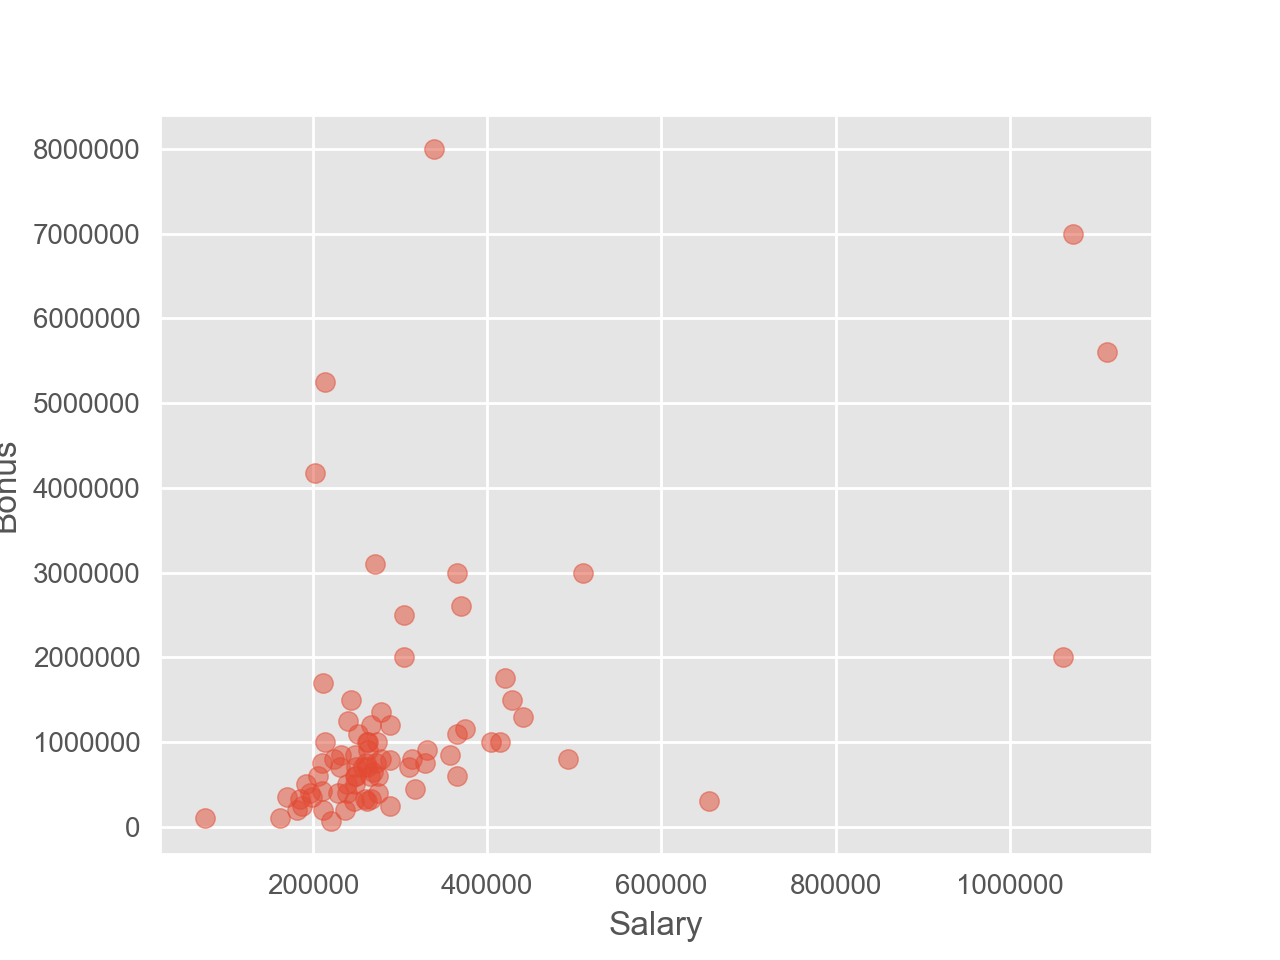

In [62]:
plt.scatter(df['salary'], df['bonus'], alpha=.5, edgecolors='face')
plt.xlabel("Salary")
plt.ylabel("Bonus")
plt.show()

### 檢視 **薪資 / 獎金** 異常是哪些人

In [16]:
bonus_outliers = []
for k, v in zip(df.index, df['bonus']):
    bonus_outliers.append((k,v))
sorted(bonus_outliers,key=lambda x:x[1],reverse=True)[:6]

[('LAVORATO JOHN J', 8000000.0),
 ('LAY KENNETH L', 7000000.0),
 ('SKILLING JEFFREY K', 5600000.0),
 ('BELDEN TIMOTHY N', 5249999.0),
 ('ALLEN PHILLIP K', 4175000.0),
 ('KITCHEN LOUISE', 3100000.0)]

In [17]:
salary_outliers = []
for k , v in zip(df.index, df['salary']):
    salary_outliers.append((k,v))
sorted(salary_outliers,key=lambda x:x[1],reverse=True)[:6]

[('SKILLING JEFFREY K', 1111258.0),
 ('LAY KENNETH L', 1072321.0),
 ('FREVERT MARK A', 1060932.0),
 ('PICKERING MARK R', 655037.0),
 ('WHALLEY LAWRENCE G', 510364.0),
 ('DERRICK JR. JAMES V', 492375.0)]

- Poi 之間的信件往來

<IPython.core.display.Javascript object>


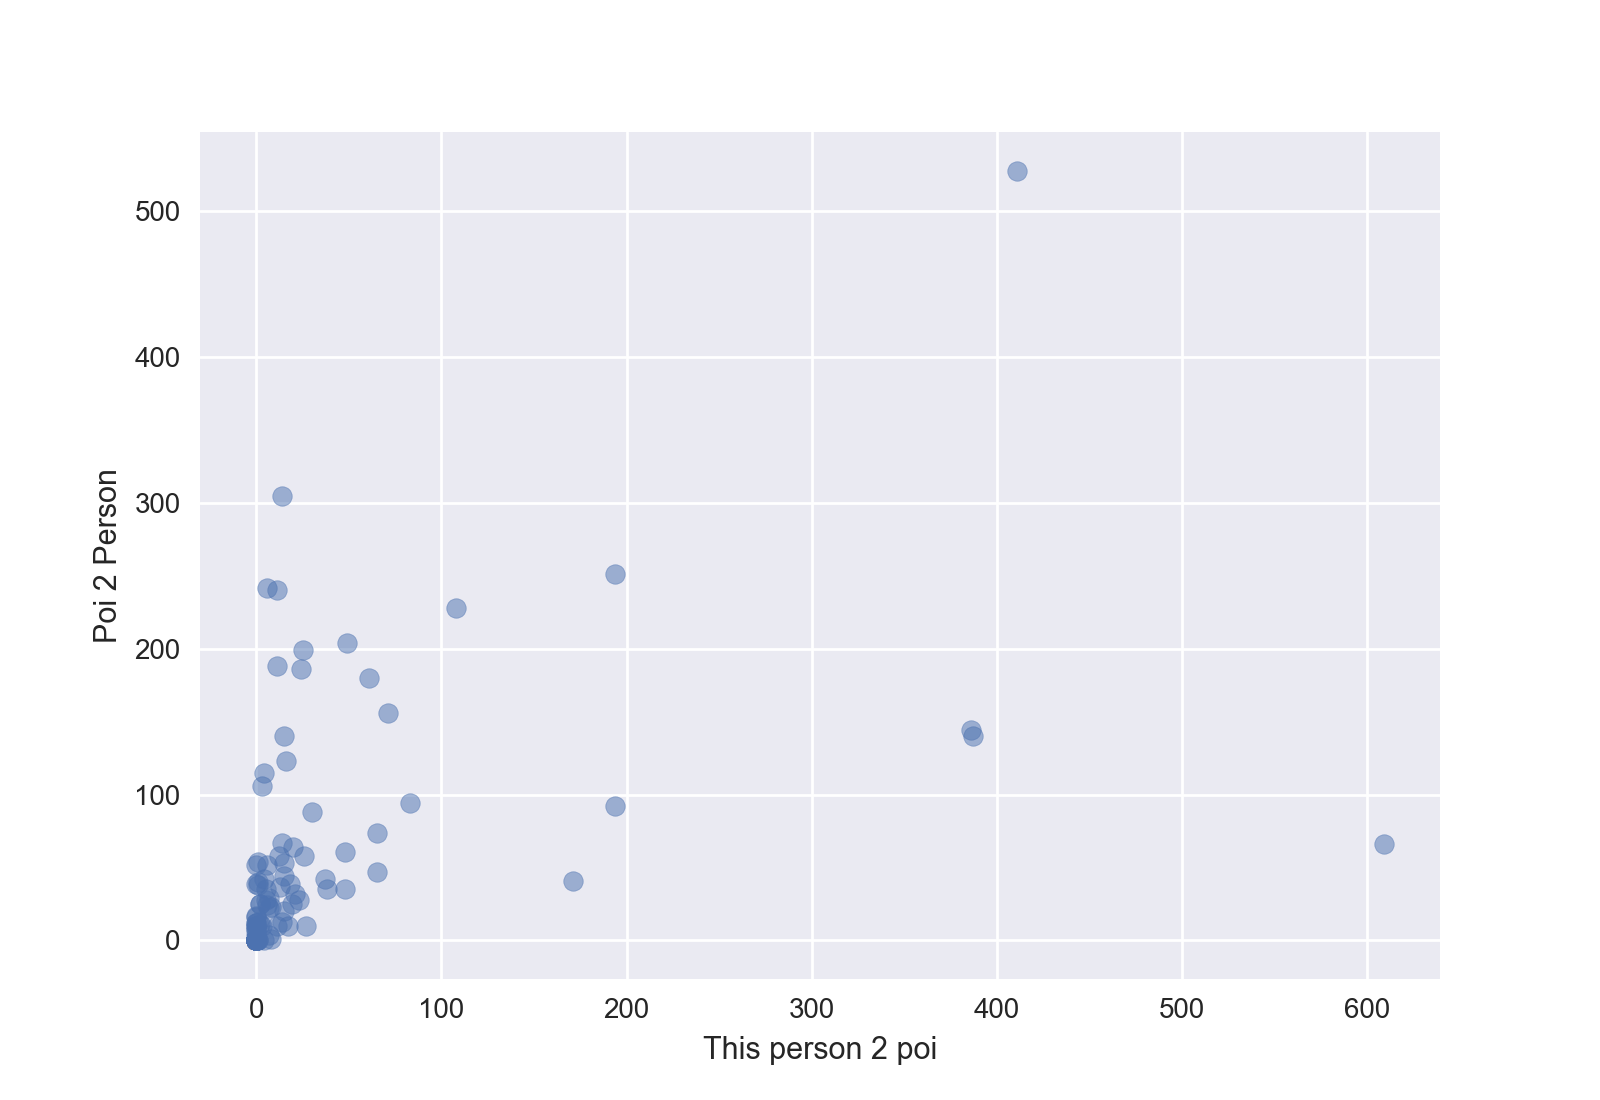

In [18]:
plt.scatter(df['from_this_person_to_poi'], df['from_poi_to_this_person'], alpha=.5, edgecolors='face')
plt.xlabel("This person 2 poi")
plt.ylabel("Poi 2 Person")
plt.show()

In [19]:
from_poi_outliers = []
for k , v in zip(df.index, df['from_poi_to_this_person']):
    from_poi_outliers.append((k,v))
sorted(from_poi_outliers,key=lambda x:x[1],reverse=True)[:6]

[('LAVORATO JOHN J', 528.0),
 ('DIETRICH JANET R', 305.0),
 ('KITCHEN LOUISE', 251.0),
 ('FREVERT MARK A', 242.0),
 ('COLWELL WESLEY', 240.0),
 ('BELDEN TIMOTHY N', 228.0)]

In [20]:
to_poi_outliers = []
for k , v in zip(df.index, df['from_this_person_to_poi']):
    to_poi_outliers.append((k,v))
sorted(to_poi_outliers,key=lambda x:x[1],reverse=True)[:6]

[('DELAINEY DAVID W', 609.0),
 ('LAVORATO JOHN J', 411.0),
 ('KEAN STEVEN J', 387.0),
 ('BECK SALLY W', 386.0),
 ('KITCHEN LOUISE', 194.0),
 ('MCCONNELL MICHAEL S', 194.0)]

#### 移除過多遺失值Feature，檢視箱形圖

In [21]:
 flt_col = ['bonus', 'exercised_stock_options', 'expenses','from_messages', 'from_poi_to_this_person',
       'from_this_person_to_poi', 'other', 'restricted_stock','salary', 'shared_receipt_with_poi', 'to_messages','total_payments', 'total_stock_value']

<IPython.core.display.Javascript object>


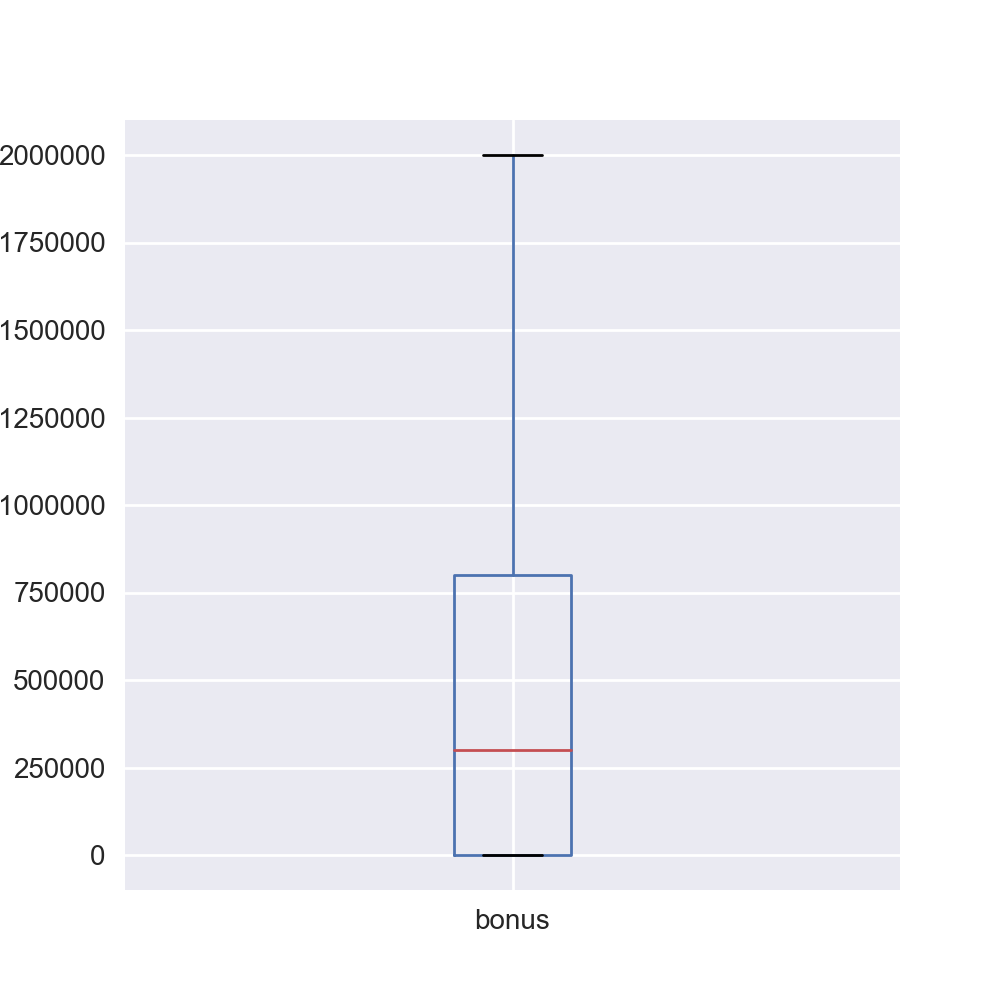

<IPython.core.display.Javascript object>


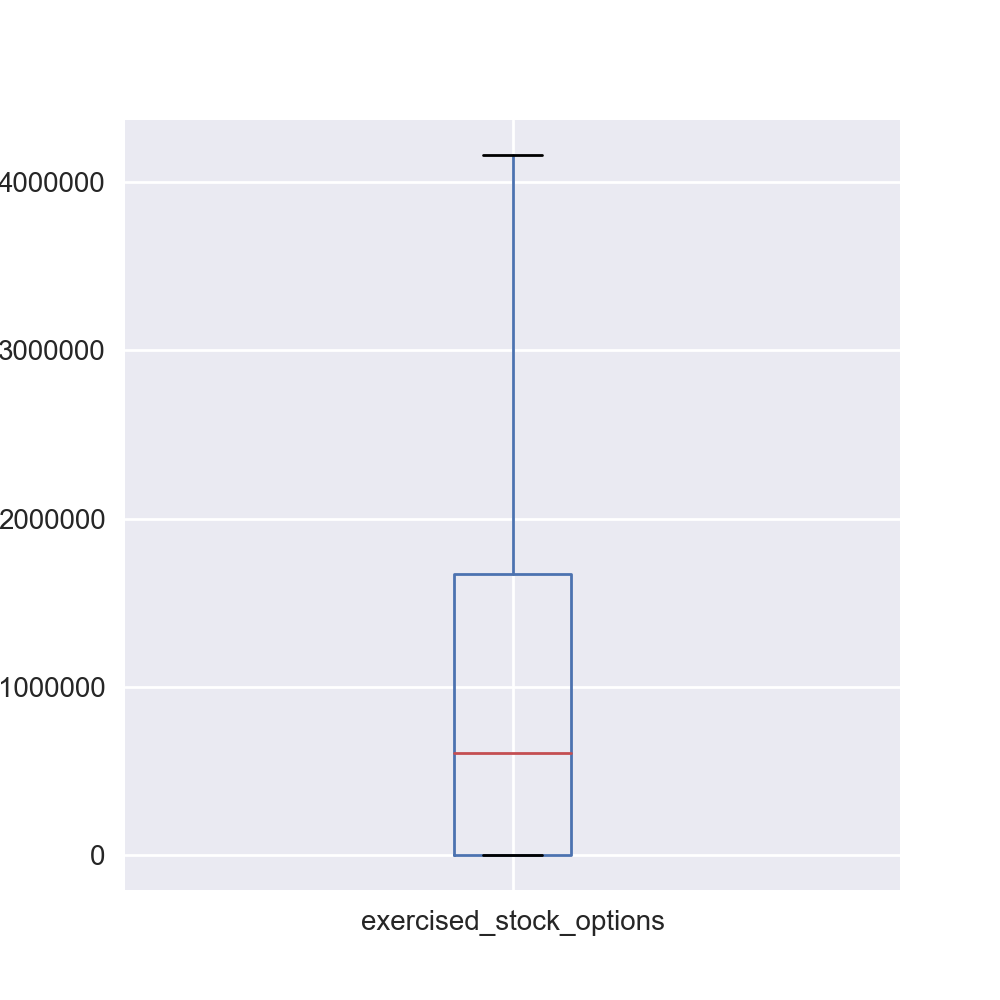

<IPython.core.display.Javascript object>


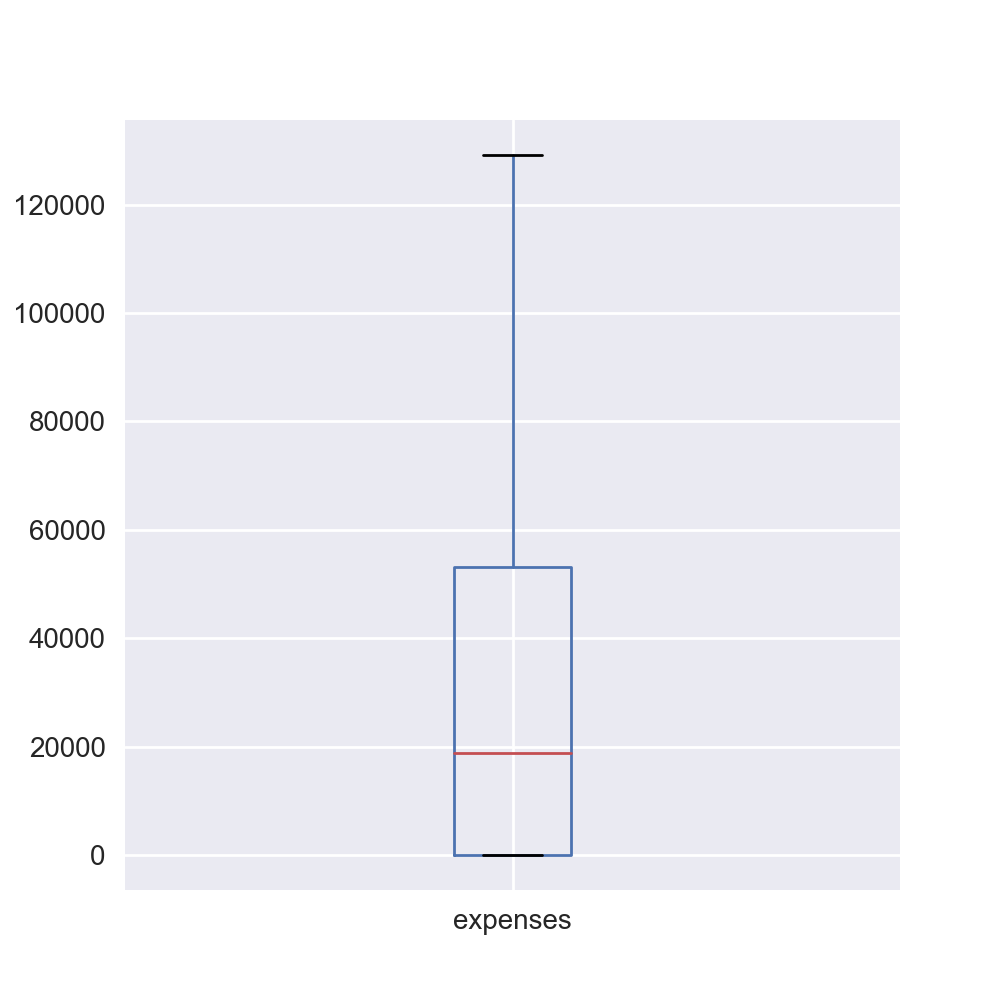

<IPython.core.display.Javascript object>


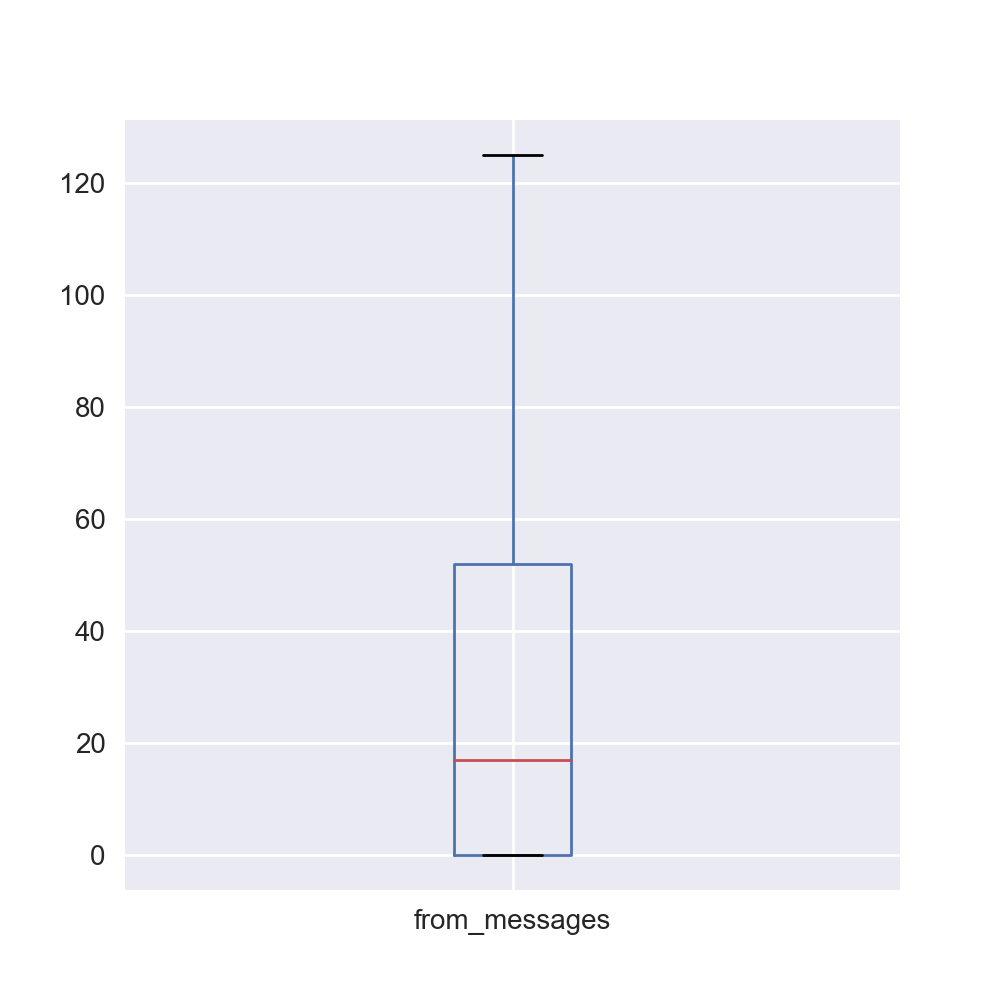

<IPython.core.display.Javascript object>


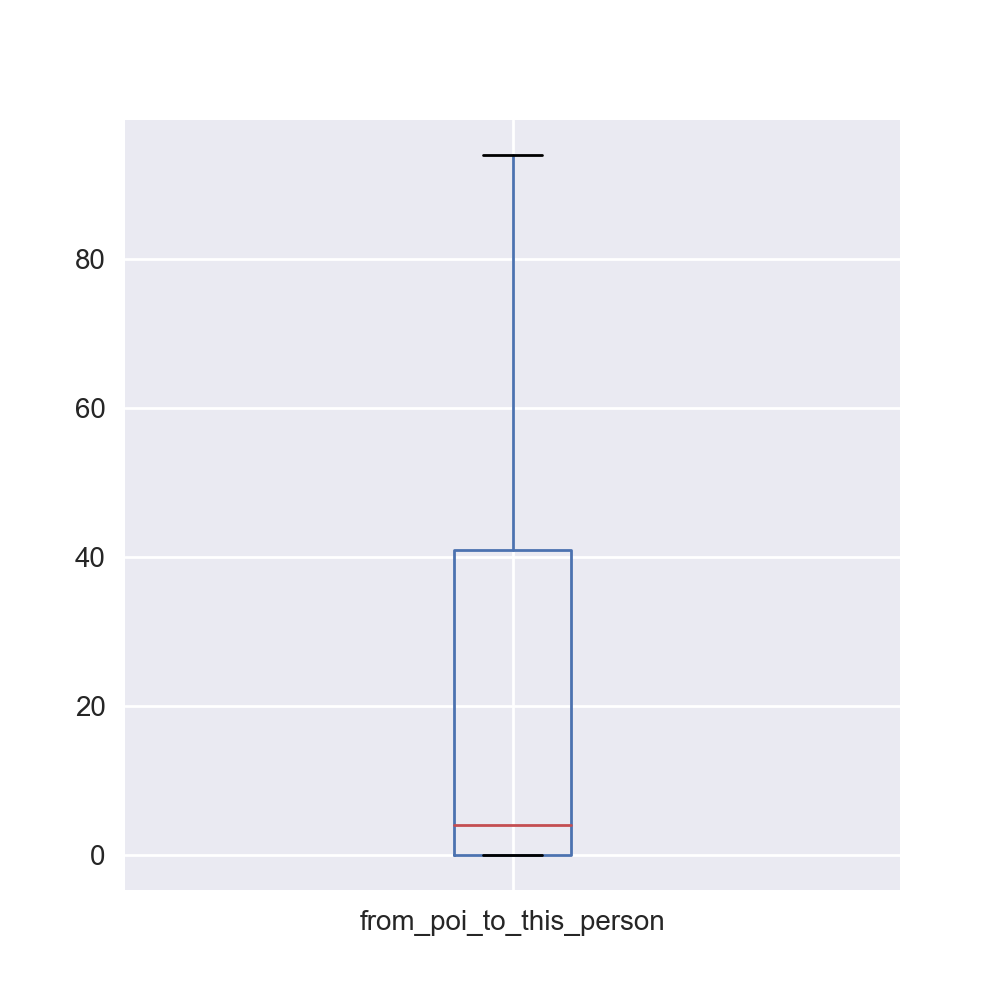

<IPython.core.display.Javascript object>


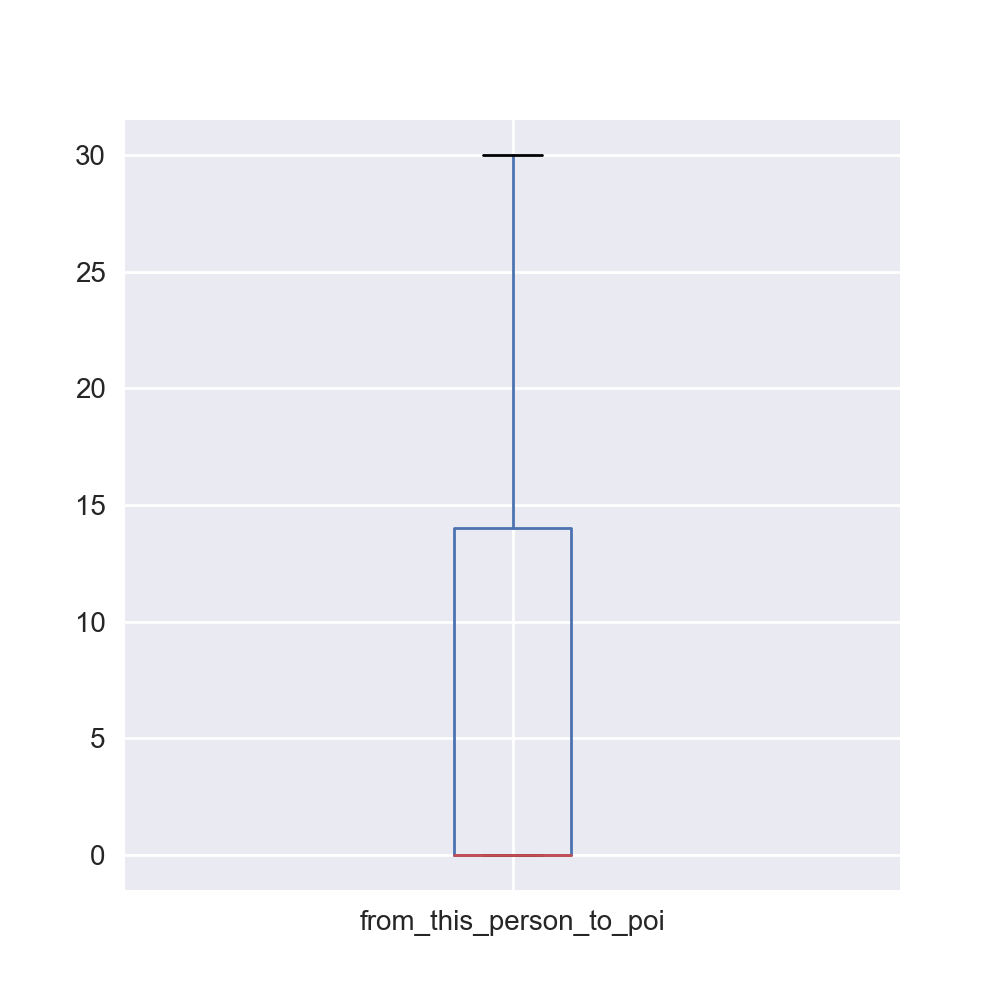

<IPython.core.display.Javascript object>


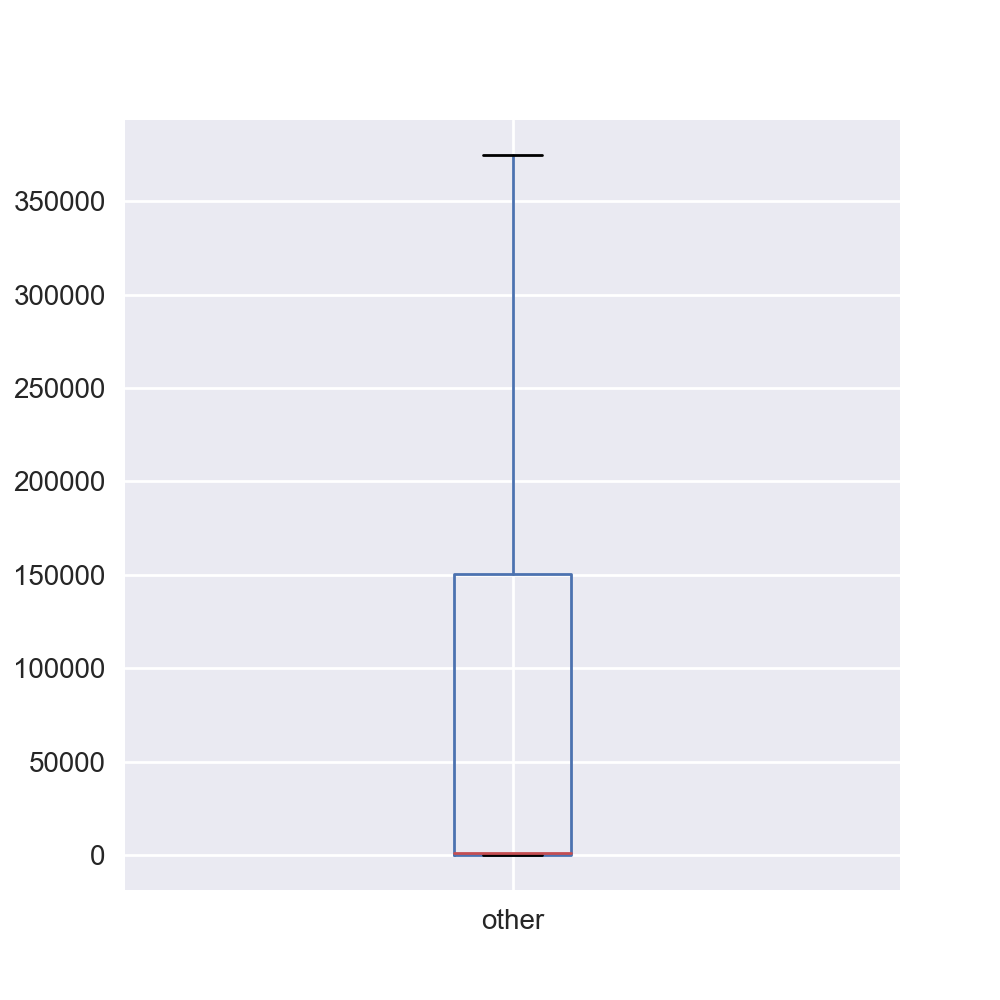

<IPython.core.display.Javascript object>


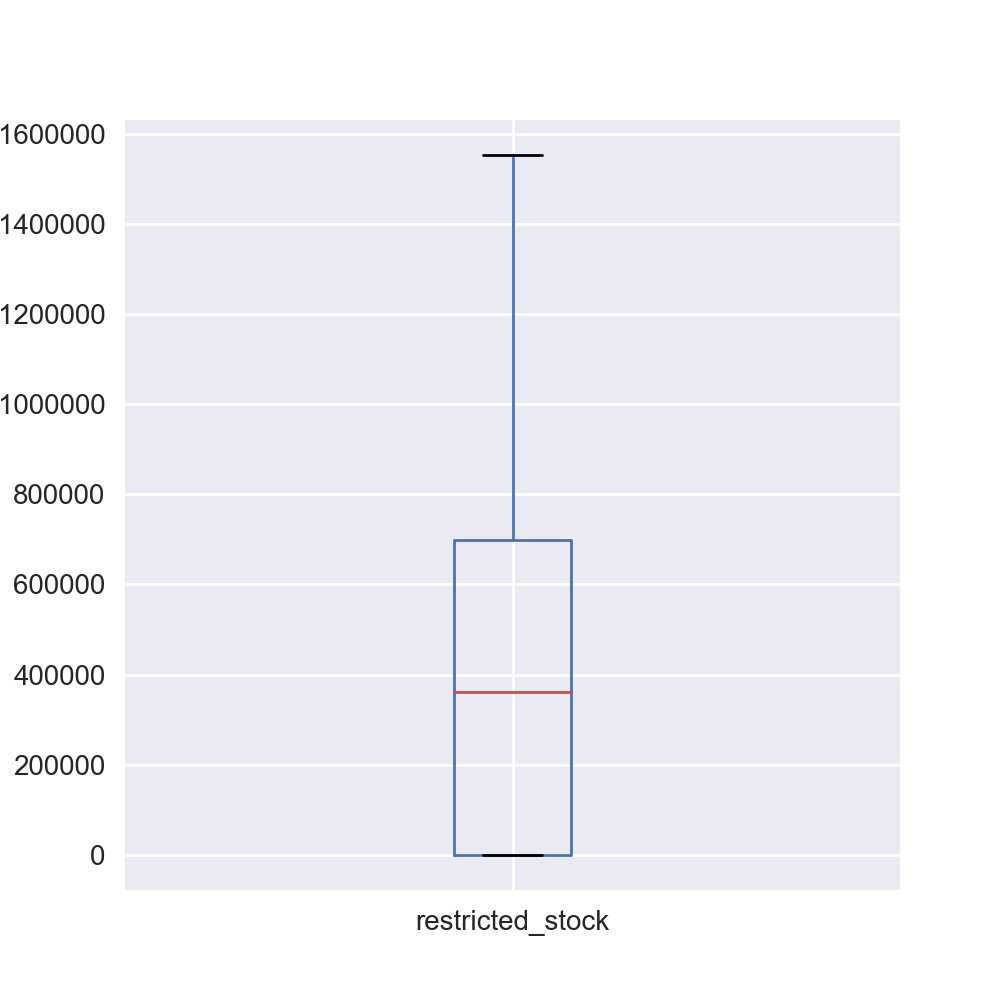

<IPython.core.display.Javascript object>


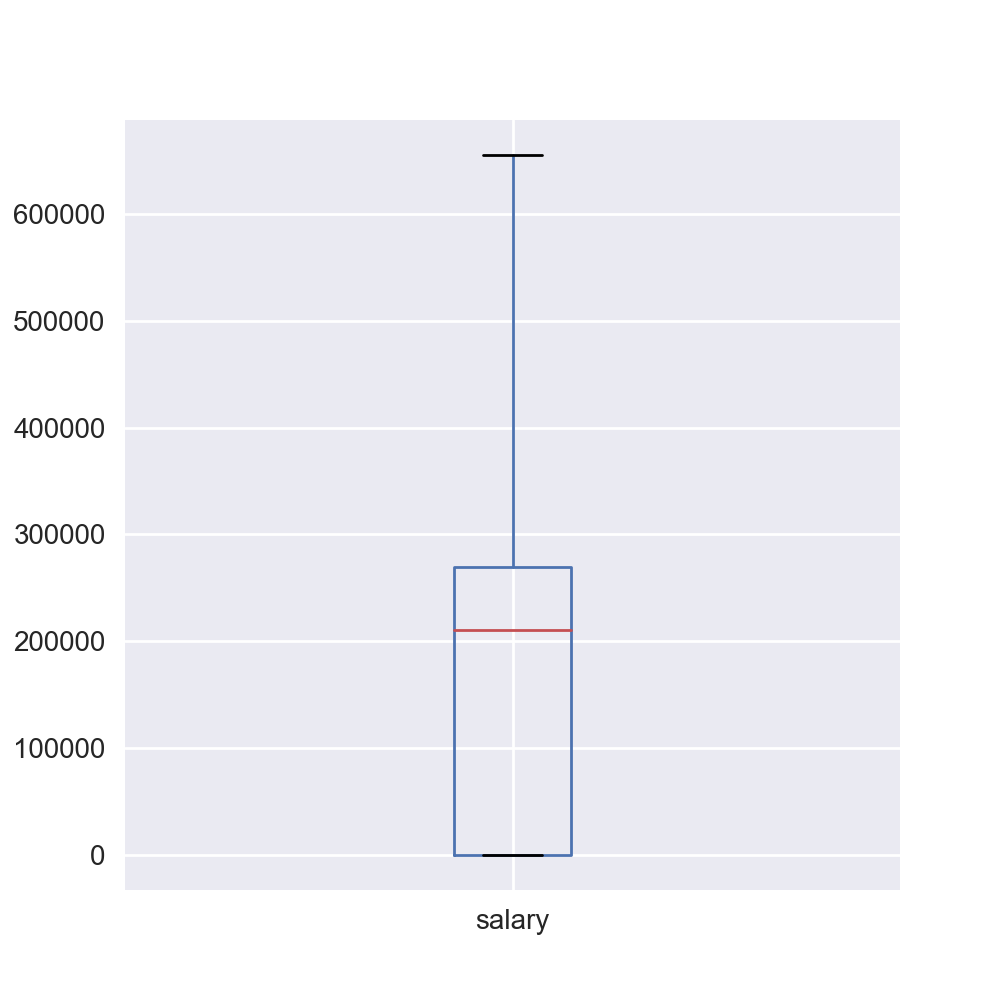

<IPython.core.display.Javascript object>


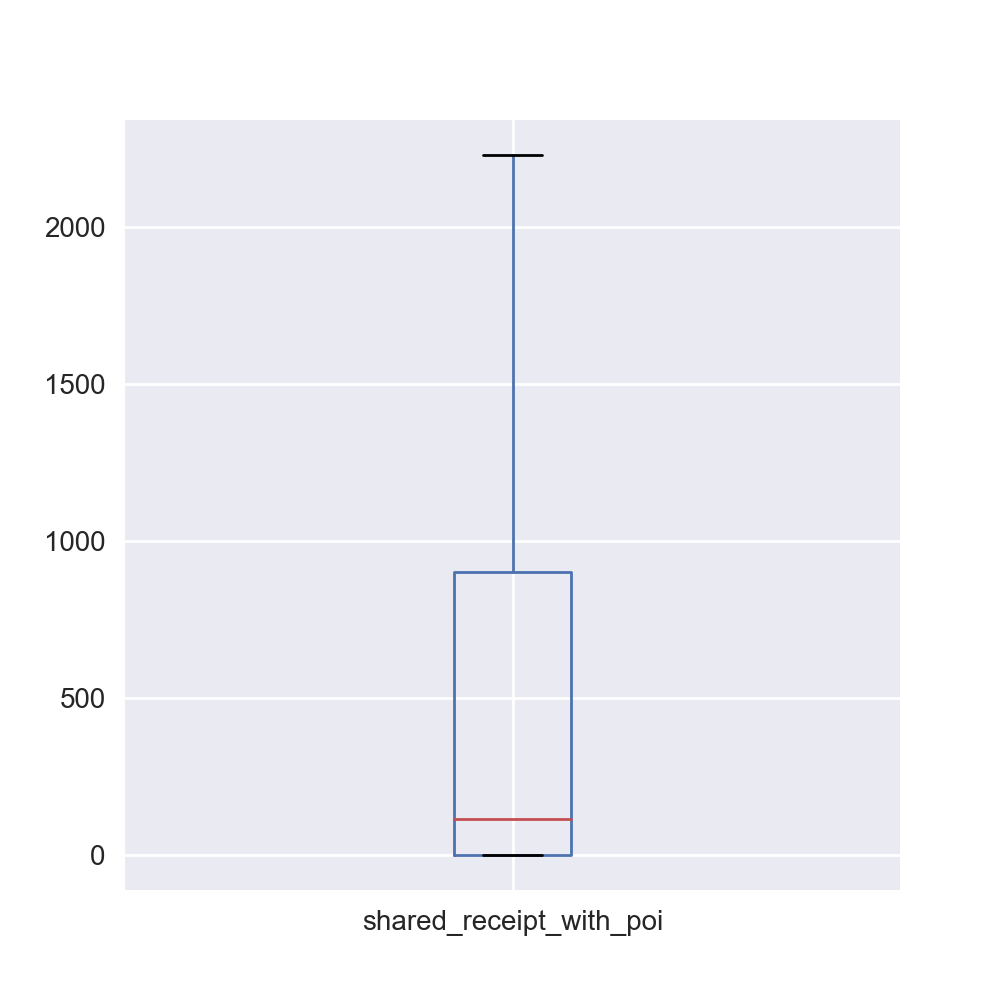

<IPython.core.display.Javascript object>


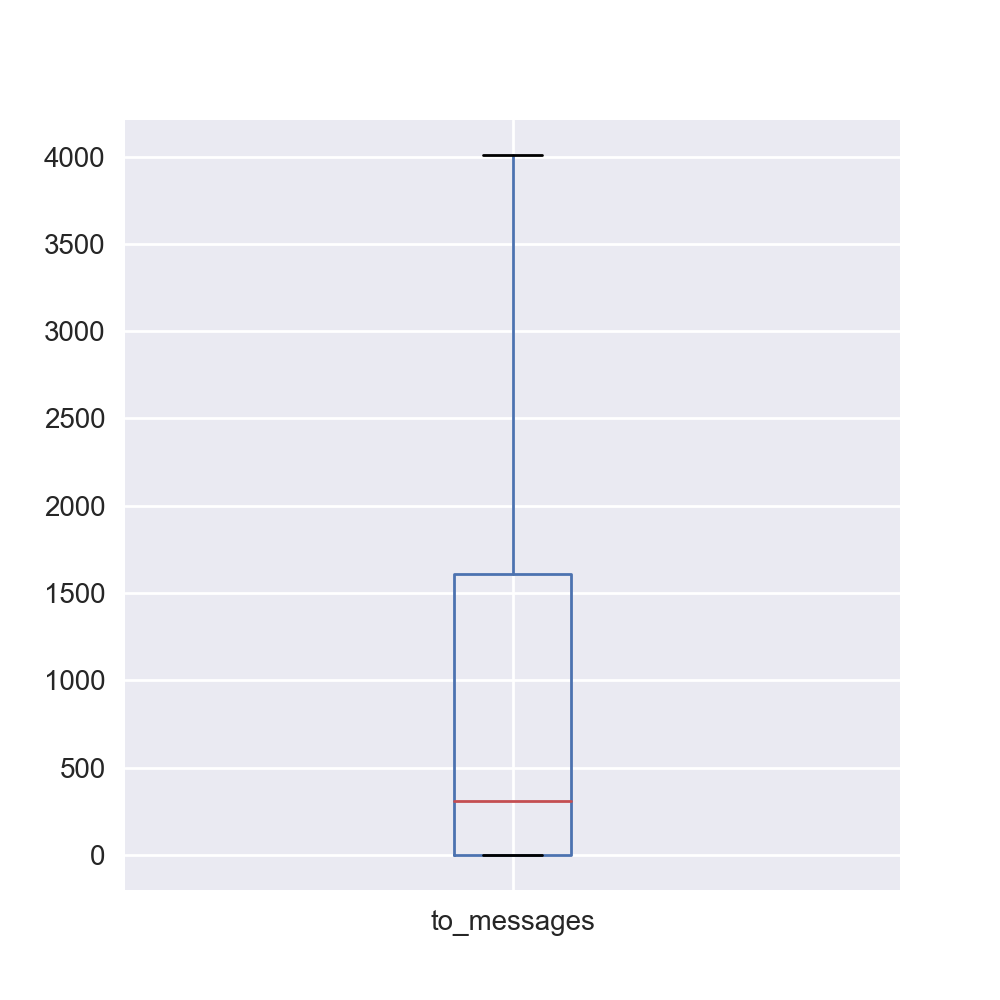

<IPython.core.display.Javascript object>


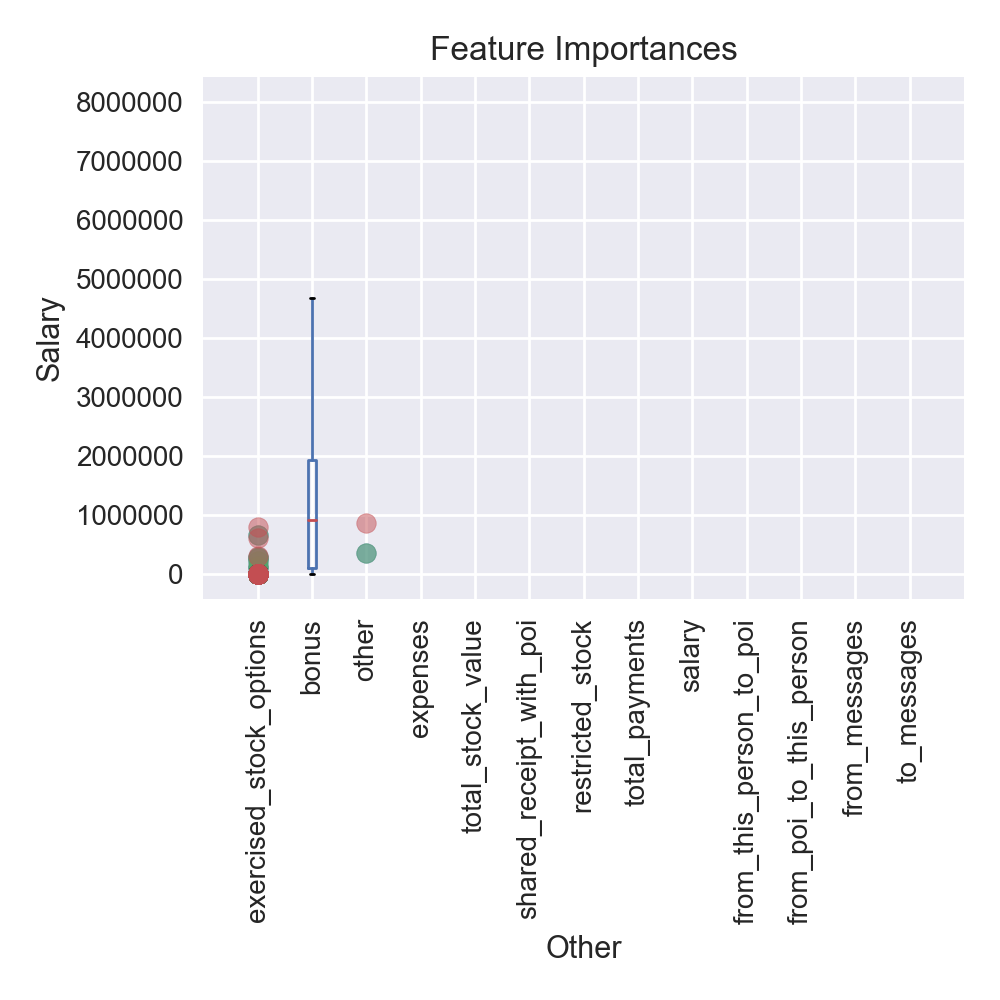

<IPython.core.display.Javascript object>


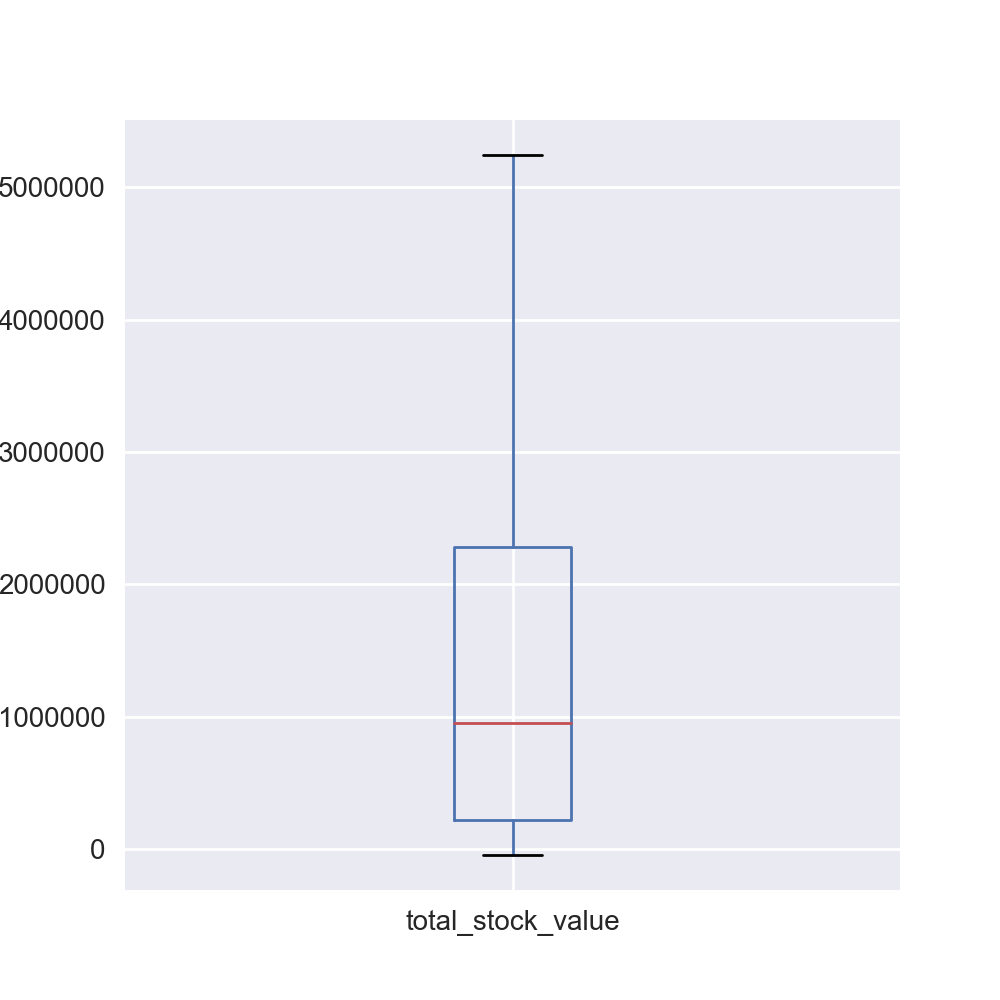

In [53]:
for i in flt_col:
    fig, ax = plt.subplots(figsize=(5, 5))
    df.boxplot(i, showfliers=False)
    #sns.boxplot(i, data=df)
    #sns.stripplot(i, data=df, jitter=True);
    plt.show()

#### 由圖得知，财务特征 **other** 異常值過度懸殊

In [15]:
other_outliers = []
for k , v in zip(df.index, df['other']):
    other_outliers.append((k,v))
sorted(other_outliers,key=lambda x:x[1],reverse=True)[:20]

[('TOTAL', 42667589.0),
 ('LAY KENNETH L', 10359729.0),
 ('FREVERT MARK A', 7427621.0),
 ('MARTIN AMANDA K', 2818454.0),
 ('BAXTER JOHN C', 2660303.0),
 ('SHERRIFF JOHN R', 1852186.0),
 ('PAI LOU L', 1829457.0),
 ('SHELBY REX', 1573324.0),
 ('IZZO LAWRENCE L', 1553729.0),
 ('WHITE JR THOMAS E', 1085463.0),
 ('KOPPER MICHAEL J', 907502.0),
 ('BANNANTINE JAMES M', 864523.0),
 ('GOLD JOSEPH', 819288.0),
 ('GRAY RODNEY', 680833.0),
 ('KISHKILL JOSEPH G', 465357.0),
 ('BERGSIEKER RICHARD P', 427316.0),
 ('THORN TERENCE H', 426629.0),
 ('BIBI PHILIPPE A', 425688.0),
 ('HERMANN ROBERT J', 416441.0),
 ('FALLON JAMES B', 401481.0)]

- 董事長 LAY KENNETH L 從other财务，收入達八位數字。
- 副董事 FREVERT MARK A 位居第二

### 檢視個體存在最多的缺失值
- NaN已經被轉成0，所以檢視最多的0值個體
- 有可能本身數據就已經是0

In [52]:
from collections import defaultdict
info = defaultdict(list)
for i in df.index:
    info[i] = 0
    for j in range(0, len(df.columns)):
        if df.loc[i][j] == 0:            
            info[i] += 1
sorted(info.items(), key=lambda x:x[1], reverse = True)[:20]

[('LOCKHART EUGENE E', 20),
 ('WODRASKA JOHN', 18),
 ('WHALEY DAVID A', 18),
 ('WROBEL BRUCE', 18),
 ('SCRIMSHAW MATTHEW', 18),
 ('THE TRAVEL AGENCY IN THE PARK', 18),
 ('GRAMM WENDY L', 18),
 ('CLINE KENNETH W', 17),
 ('WAKEHAM JOHN', 17),
 ('GILLIS JOHN', 17),
 ('CHRISTODOULOU DIOMEDES', 17),
 ('SAVAGE FRANK', 17),
 ('LOWRY CHARLES P', 16),
 ('CHAN RONNIE', 16),
 ('URQUHART JOHN A', 16),
 ('MENDELSOHN JOHN', 16),
 ('MEYER JEROME J', 16),
 ('GATHMANN WILLIAM D', 16),
 ('PEREIRA PAULO V. FERRAZ', 16),
 ('BLAKE JR. NORMAN P', 16)]

### 'LOCKHART EUGENE E' 全部為NaN，沒有訊息含量

In [11]:
df = df.drop('LOCKHART EUGENE E')

In [12]:
del data_dict['LOCKHART EUGENE E']

### 'THE TRAVEL AGENCY IN THE PARK'，不屬於個體，刪除此欄位。


In [13]:
df = df.drop('THE TRAVEL AGENCY IN THE PARK')

In [14]:
del data_dict['THE TRAVEL AGENCY IN THE PARK']

## 优化特征选择/工程
1. 创建新特征
    - 测试了该特征对最终算法性能的影响。
    - 未要求学生将新特征包含在其最终特征集内。
2. 明智地选择特征
    - 尝试了不同的特征组合，并记录了每种组合的性能
3. 适当缩放特征
    - 若算法要求缩放的特征，则部署特征缩放。

### 创建新特征

In [15]:
for items in data_dict:
        data_dict[items]['key_payments'] = data_dict[items]['salary'] + data_dict[items]['bonus'] + data_dict[items]['other']
        data_dict[items]['retention_incentives'] = data_dict[items]['long_term_incentive'] + data_dict[items]['total_stock_value']
        if data_dict[items]['salary'] != 0:
            data_dict[items]['bonus/salary'] = data_dict[items]['bonus']/data_dict[items]['salary']
            data_dict[items]['exercised_stock_options/salary'] = data_dict[items]['exercised_stock_options']/data_dict[items]['salary']
        else:
            data_dict[items]['bonus/salary'] = 0
            data_dict[items]['exercised_stock_options/salary'] = 0
        if data_dict[items]['key_payments'] != 0:
            data_dict[items]['retention_incentives/key_payments'] = data_dict[items]['retention_incentives']/data_dict[items]['key_payments']
        else:
            data_dict[items]['retention_incentives/key_payments'] = 0
        messagetotal = data_dict[items]['from_messages'] + data_dict[items]['to_messages']
        if messagetotal > 0:
            poitotal = data_dict[items]['from_this_person_to_poi'] + data_dict[items]['from_poi_to_this_person']
            data_dict[items]['poi_emailratio'] = poitotal/messagetotal
        else:
            data_dict[items]['poi_emailratio'] = 0

In [21]:
df = pd.DataFrame(data_dict).T
df.head()

bonus  bonus/salary  deferral_payments  \
ALLEN PHILLIP K     4175000.0     20.672922          2869717.0   
BADUM JAMES P             0.0      0.000000           178980.0   
BANNANTINE JAMES M        0.0      0.000000                0.0   
BAXTER JOHN C       1200000.0      4.492666          1295738.0   
BAY FRANKLIN R       400000.0      1.668955           260455.0   

                    deferred_income  director_fees  exercised_stock_options  \
ALLEN PHILLIP K          -3081055.0            0.0                1729541.0   
BADUM JAMES P                   0.0            0.0                 257817.0   
BANNANTINE JAMES M          -5104.0            0.0                4046157.0   
BAXTER JOHN C            -1386055.0            0.0                6680544.0   
BAY FRANKLIN R            -201641.0            0.0                      0.0   

                    exercised_stock_options/salary  expenses  from_messages  \
ALLEN PHILLIP K                           8.563992   13868.0         2195.0   
BADUM JAMES P                             0.000000    3486.0            0.0   
BANNANTINE JAMES M                     8482.509434   56301.0           29.0   
BAXTER JOHN C                            25.011209   11200.0            0.0   
BAY FRANKLIN R                            0.000000  129142.0            0.0   

                    from_poi_to_this_person        ...          \
ALLEN PHILLIP K                        47.0        ...           
BADUM JAMES P                           0.0        ...           
BANNANTINE JAMES M                     39.0        ...           
BAXTER JOHN C                           0.0        ...           
BAY FRANKLIN R                          0.0        ...           

                    poi_emailratio  restricted_stock  \
ALLEN PHILLIP K           0.021974          126027.0   
BADUM JAMES P             0.000000               0.0   
BANNANTINE JAMES M        0.065546         1757552.0   
BAXTER JOHN C             0.000000         3942714.0   
BAY FRANKLIN R            0.000000          145796.0   

                    restricted_stock_deferred  retention_incentives  \
ALLEN PHILLIP K                     -126027.0             2034346.0   
BADUM JAMES P                             0.0              257817.0   
BANNANTINE JAMES M                  -560222.0             5243487.0   
BAXTER JOHN C                             0.0            12209313.0   
BAY FRANKLIN R                       -82782.0               63014.0   

                    retention_incentives/key_payments    salary  \
ALLEN PHILLIP K                              0.464770  201955.0   
BADUM JAMES P                                0.000000       0.0   
BANNANTINE JAMES M                           6.061835     477.0   
BAXTER JOHN C                                2.958109  267102.0   
BAY FRANKLIN R                               0.098499  239671.0   

                    shared_receipt_with_poi  to_messages  total_payments  \
ALLEN PHILLIP K                      1407.0       2902.0       4484442.0   
BADUM JAMES P                           0.0          0.0        182466.0   
BANNANTINE JAMES M                    465.0        566.0        916197.0   
BAXTER JOHN C                           0.0          0.0       5634343.0   
BAY FRANKLIN R                          0.0          0.0        827696.0   

                    total_stock_value  
ALLEN PHILLIP K             1729541.0  
BADUM JAMES P                257817.0  
BANNANTINE JAMES M          5243487.0  
BAXTER JOHN C              10623258.0  
BAY FRANKLIN R                63014.0  

[5 rows x 26 columns]

### 选择特征 / 特徵縮放


- 特徵縮放

In [22]:
features_list = df.drop('poi', axis = 1).columns.values
X_train = df[features_list]
y_train = df.poi.values

In [23]:
Stand = StandardScaler()
MinMax = MinMaxScaler()
X_train = MinMax.fit_transform(X_train)

<IPython.core.display.Javascript object>


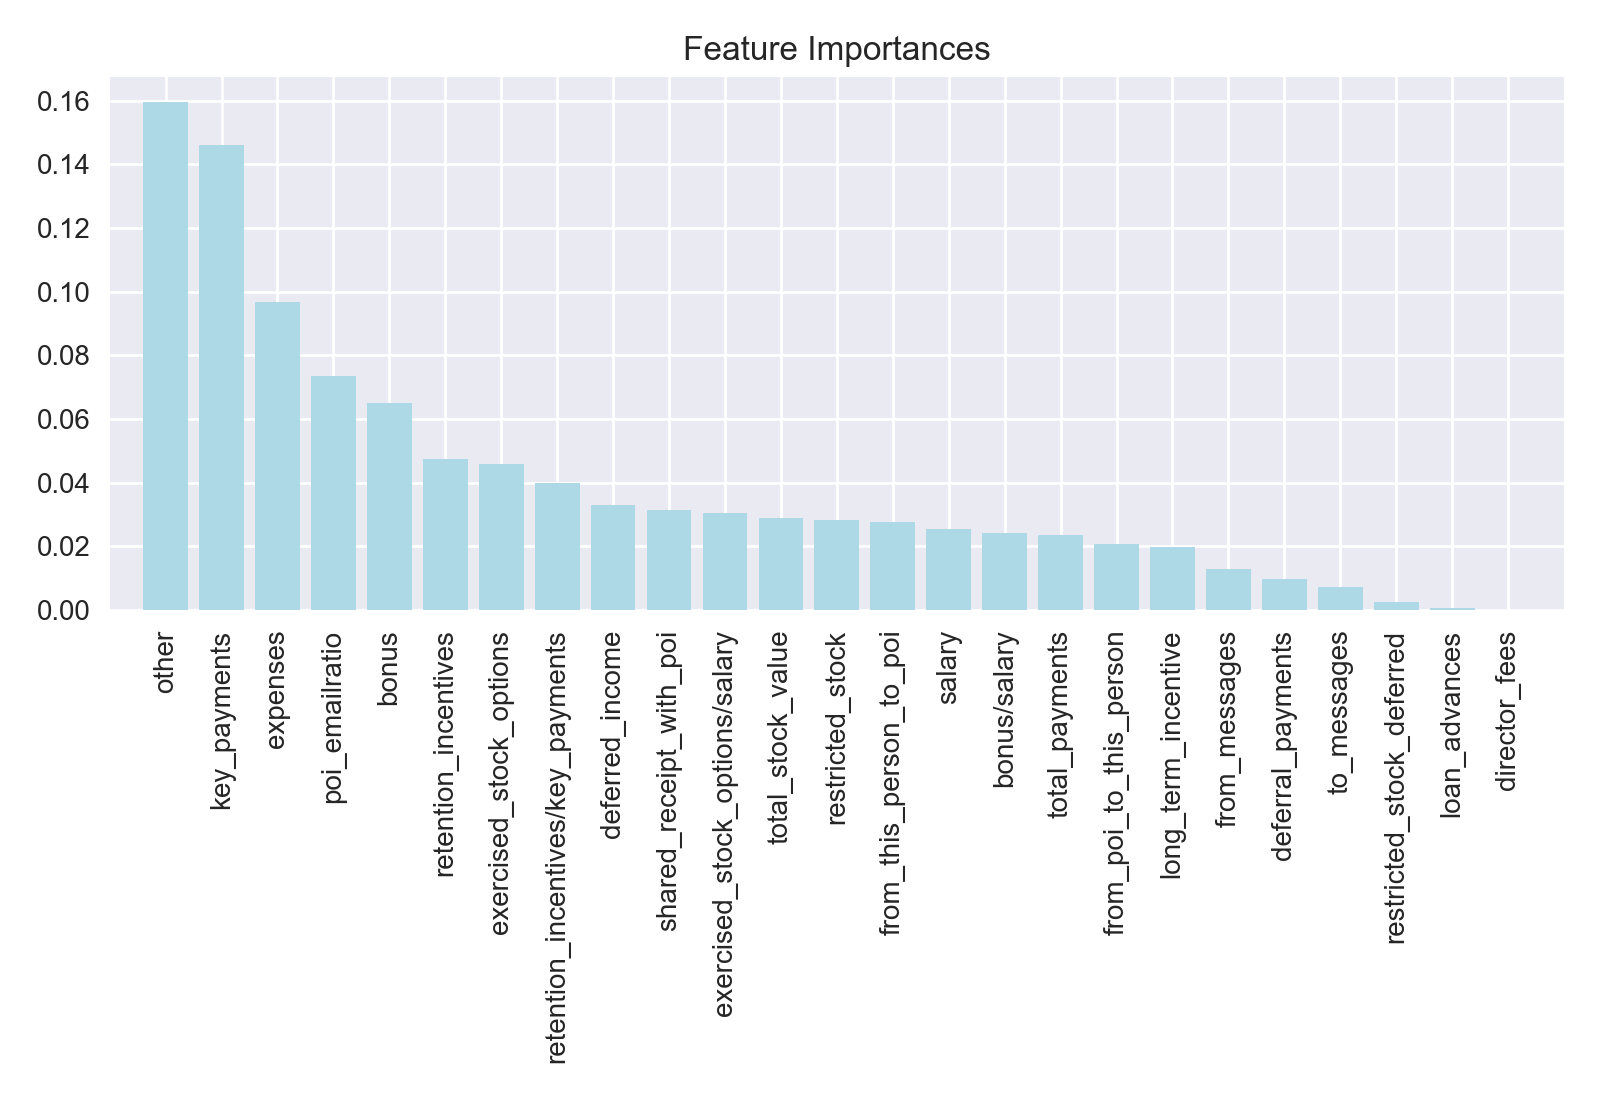

In [27]:

feat_labels = df[features_list].columns

forest = RandomForestClassifier(n_estimators=100,
                                criterion = 'entropy',
                                max_features = None,
                                max_depth = 5,
                                random_state=42,
                                n_jobs=-1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

###  依據比重，排除特徵權重低於0.02的選項

In [90]:
list(feat_labels[indices])#[:-7]

['other',
 'key_payments',
 'expenses',
 'poi_emailratio',
 'bonus',
 'retention_incentives',
 'exercised_stock_options',
 'retention_incentives/key_payments',
 'deferred_income',
 'shared_receipt_with_poi',
 'exercised_stock_options/salary',
 'total_stock_value',
 'restricted_stock',
 'from_this_person_to_poi',
 'salary',
 'bonus/salary',
 'total_payments',
 'from_poi_to_this_person',
 'long_term_incentive',
 'from_messages',
 'deferral_payments',
 'to_messages',
 'restricted_stock_deferred',
 'loan_advances',
 'director_fees']

In [92]:
Features = list(feat_labels[indices])#[:-5]
X_train = df[Features]
print('Total Importance Features : %d'%(len(Features)))

Total Importance Features : 25


## 查看新創特徵，彼此之間的相關性，進行篩選
    - key_payments ＝salary + bonus + others
    - retention_incentives ＝ long_term_incentive + total_stock_value  
    - bonus/salary
    - exercised_stock_options/salary
    - retention_incentives/key_payments
    - messagetotal = from_messages + to_messages 
    - poitotal = from_this_person_to_poi + from_poi_to_this_person
    - poi_emailratio = poitotal/messagetotal



<IPython.core.display.Javascript object>


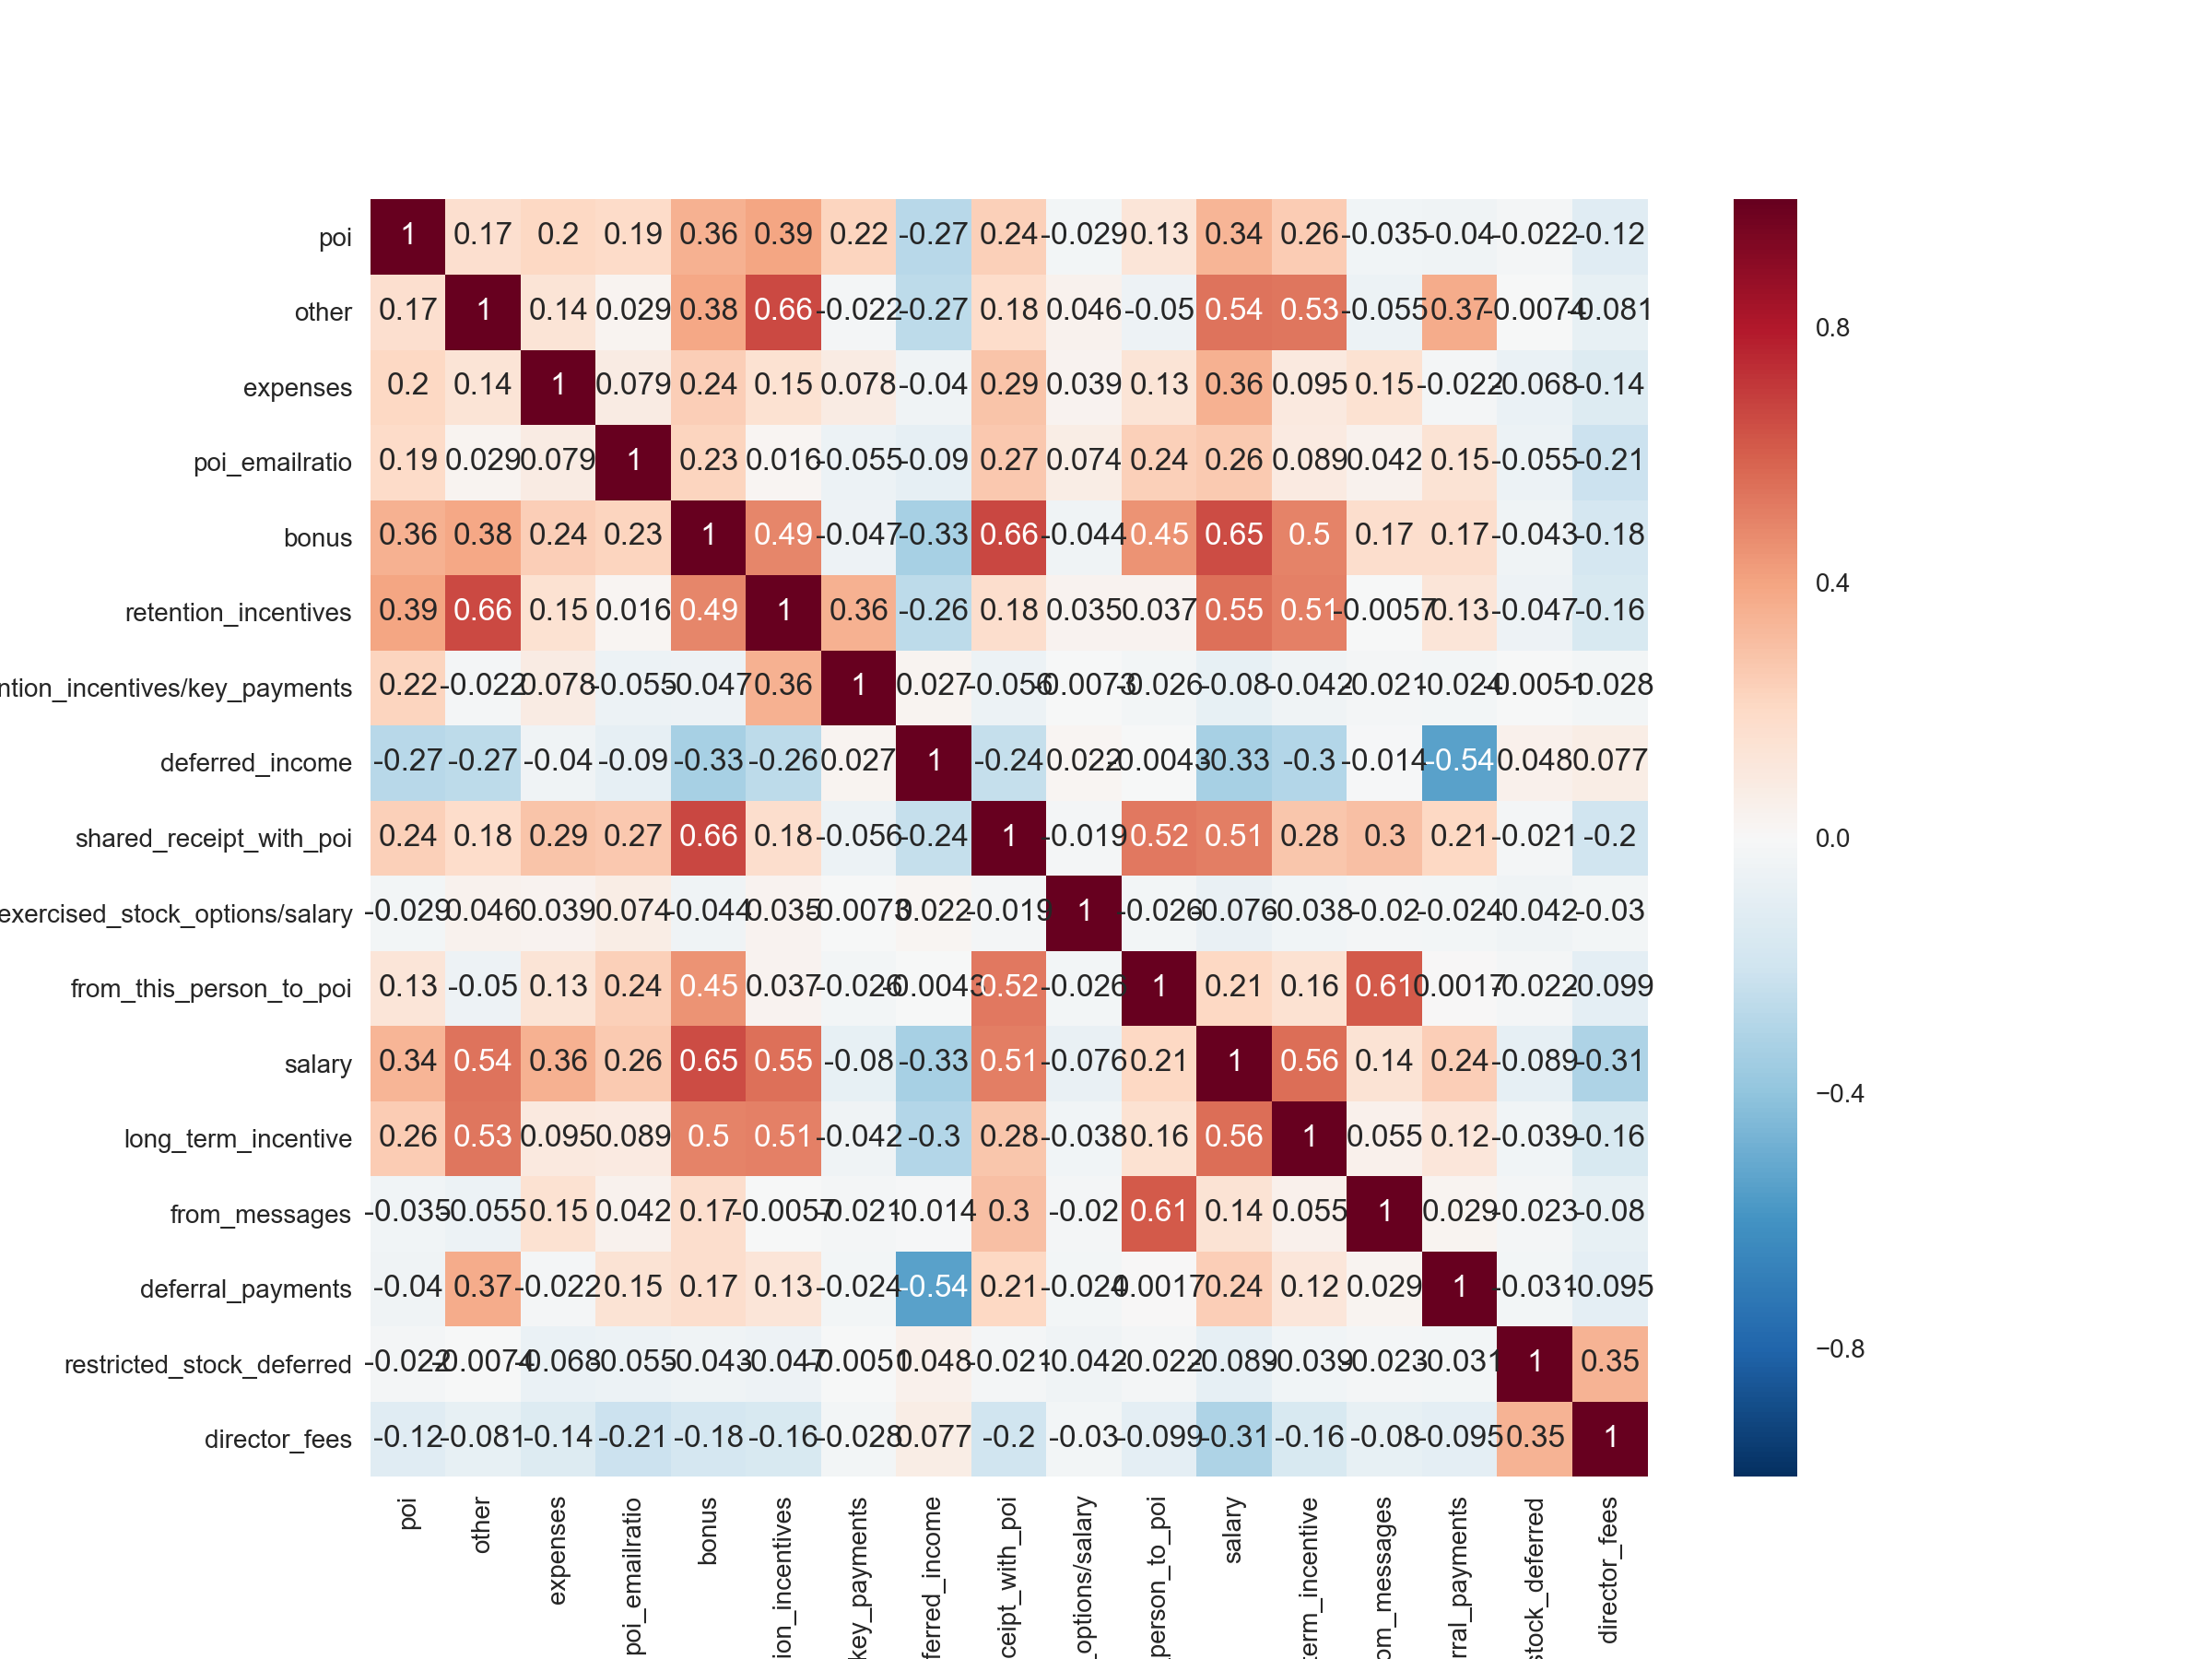

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5]),
 <a list of 17 Text yticklabel objects>)

In [93]:
hicorr = ('key_payments','total_payments','exercised_stock_options','to_messages','loan_advances','bonus/salary','restricted_stock','total_stock_value','from_poi_to_this_person')
Features.insert(0, "poi")
Features= [x for x in Features if x not in hicorr]
corrmat = df[Features].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, annot=True,  square=True);
plt.xticks(rotation=90) 
plt.yticks(rotation=0) 

## 选择和调整算法
1. 选择算法
2. 参数调整
3. 调整算法
    - 使用 GridSearchCV 进行参数调整
    - 调整了多个参数
    - 参数调整融入了算法部分

## 验证和评估
1. 评估度量的使用
    - 至少使用了两个适当度量来评估算法性能
2. 验证及其重要性
    - 回复解决了什么是验证以及它的重要性
3. 验证策略
    - 将数据拆分为培训和测试集或使用交叉验证，并说明所执行验证的具体类型。
4. 算法性能
    - 精确度、召回率均至少为 0.3。

### 選擇算法

In [94]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
dt_clf = DecisionTreeClassifier()
rf_clf = RandomForestClassifier()
ad_clf = AdaBoostClassifier(base_estimator = GaussianNB())
gb_clf = GradientBoostingClassifier()
nb_clf = GaussianNB()
vot_clf = VotingClassifier(estimators=[('dt', dt_clf), ('rf',rf_clf),('ad', ad_clf),('nb', nb_clf)], voting='hard')

### 验证策略
- 把數據拆開，訓練/測試

In [95]:
Features.remove('poi')
X_train, y_train = df[Features], df.poi.values
Xtrain, Xtest, ytrain, ytest = train_test_split(X_train, y_train, test_size = 0.2, random_state = None)
MinMax = MinMaxScaler()
Xtrain = MinMax.fit_transform(Xtrain)
Xtest = MinMax.fit_transform(Xtest)

In [96]:
my_dataset = data_dict
data = featureFormat(my_dataset, Features, sort_keys = True)
labels, features = targetFeatureSplit(data)

### 未調參之前，模型表現
- 比較 訓練/測試 accuracy_score 的表現，判斷是否overfitting
- Recall - Precision curve
- Roc Curve

<IPython.core.display.Javascript object>


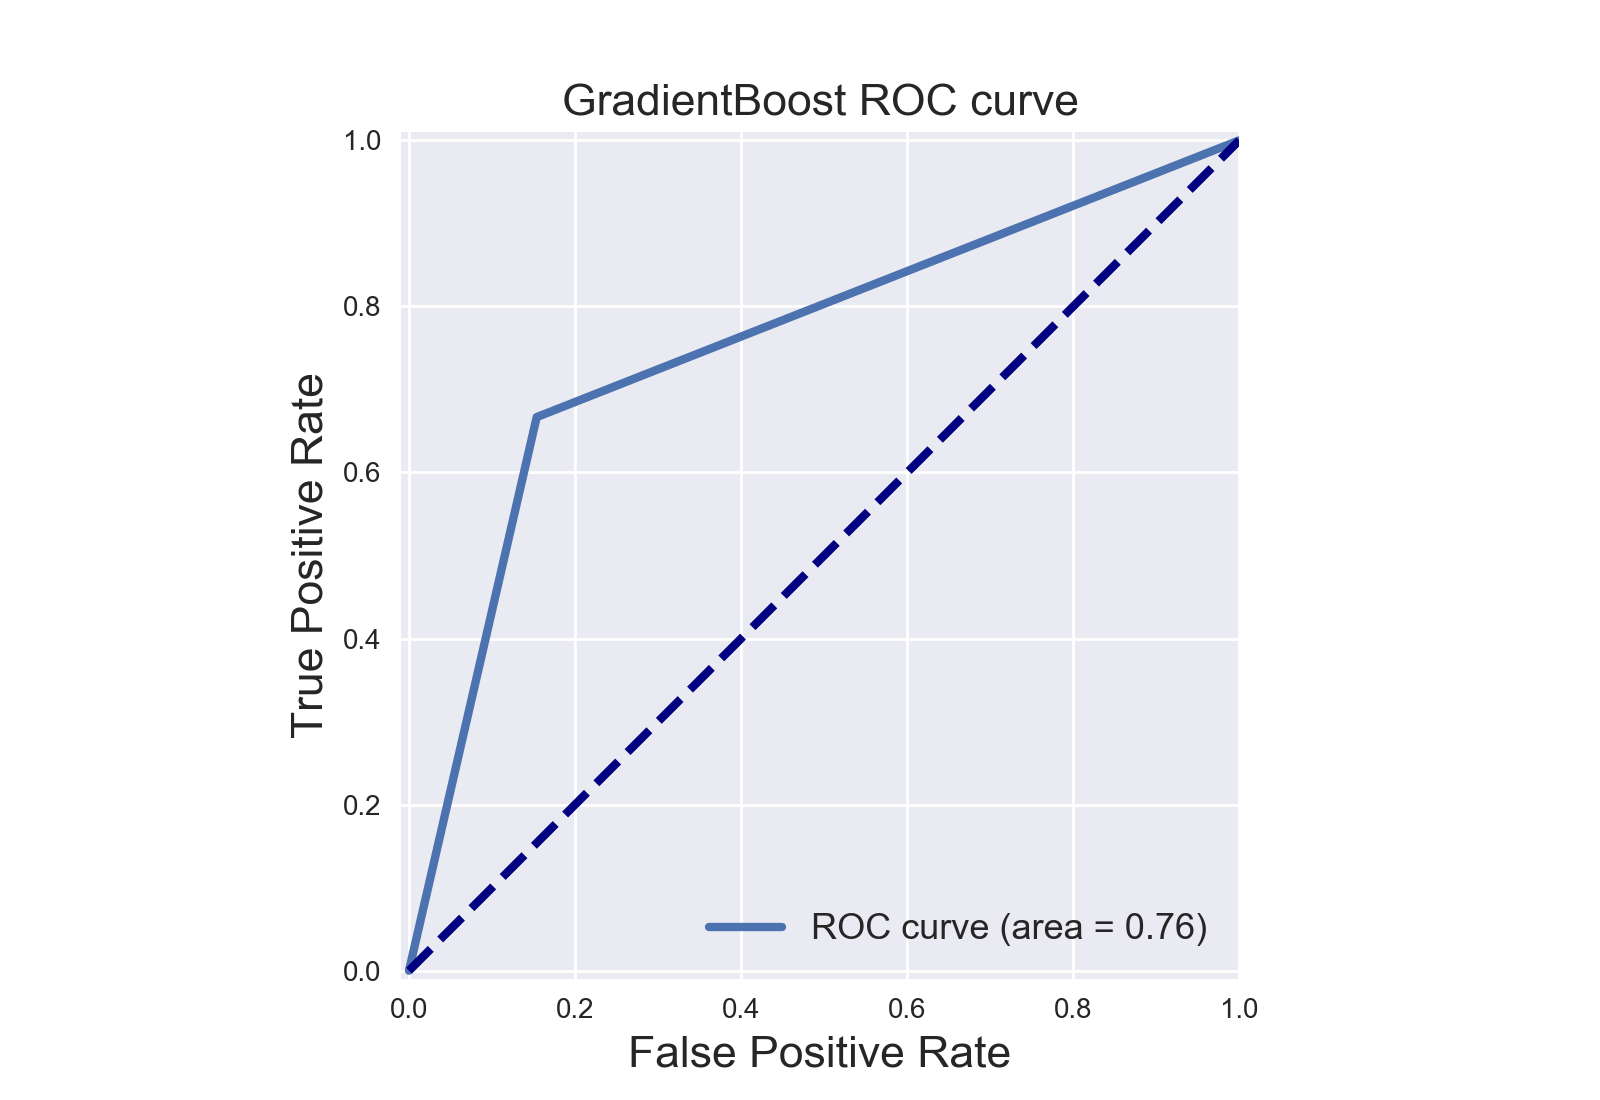

<IPython.core.display.Javascript object>


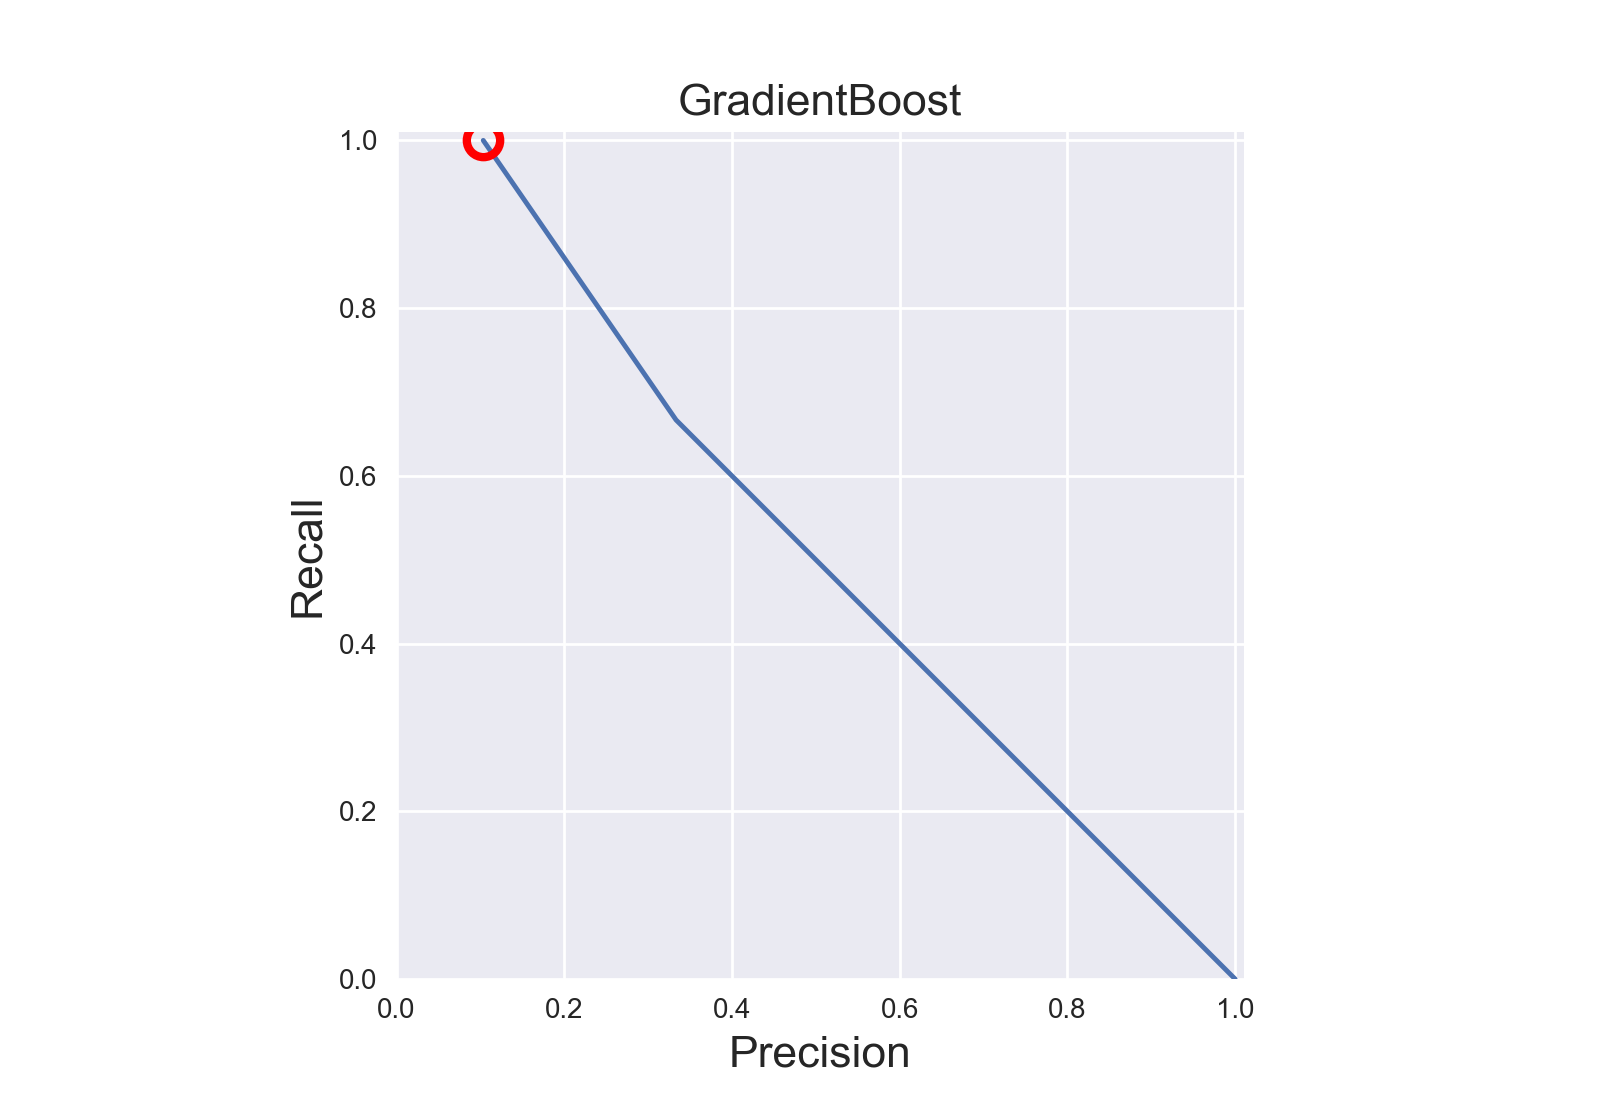

GradientBoost 
             precision    recall  f1-score   support

        0.0       0.96      0.85      0.90        26
        1.0       0.33      0.67      0.44         3

avg / total       0.89      0.83      0.85        29



<IPython.core.display.Javascript object>


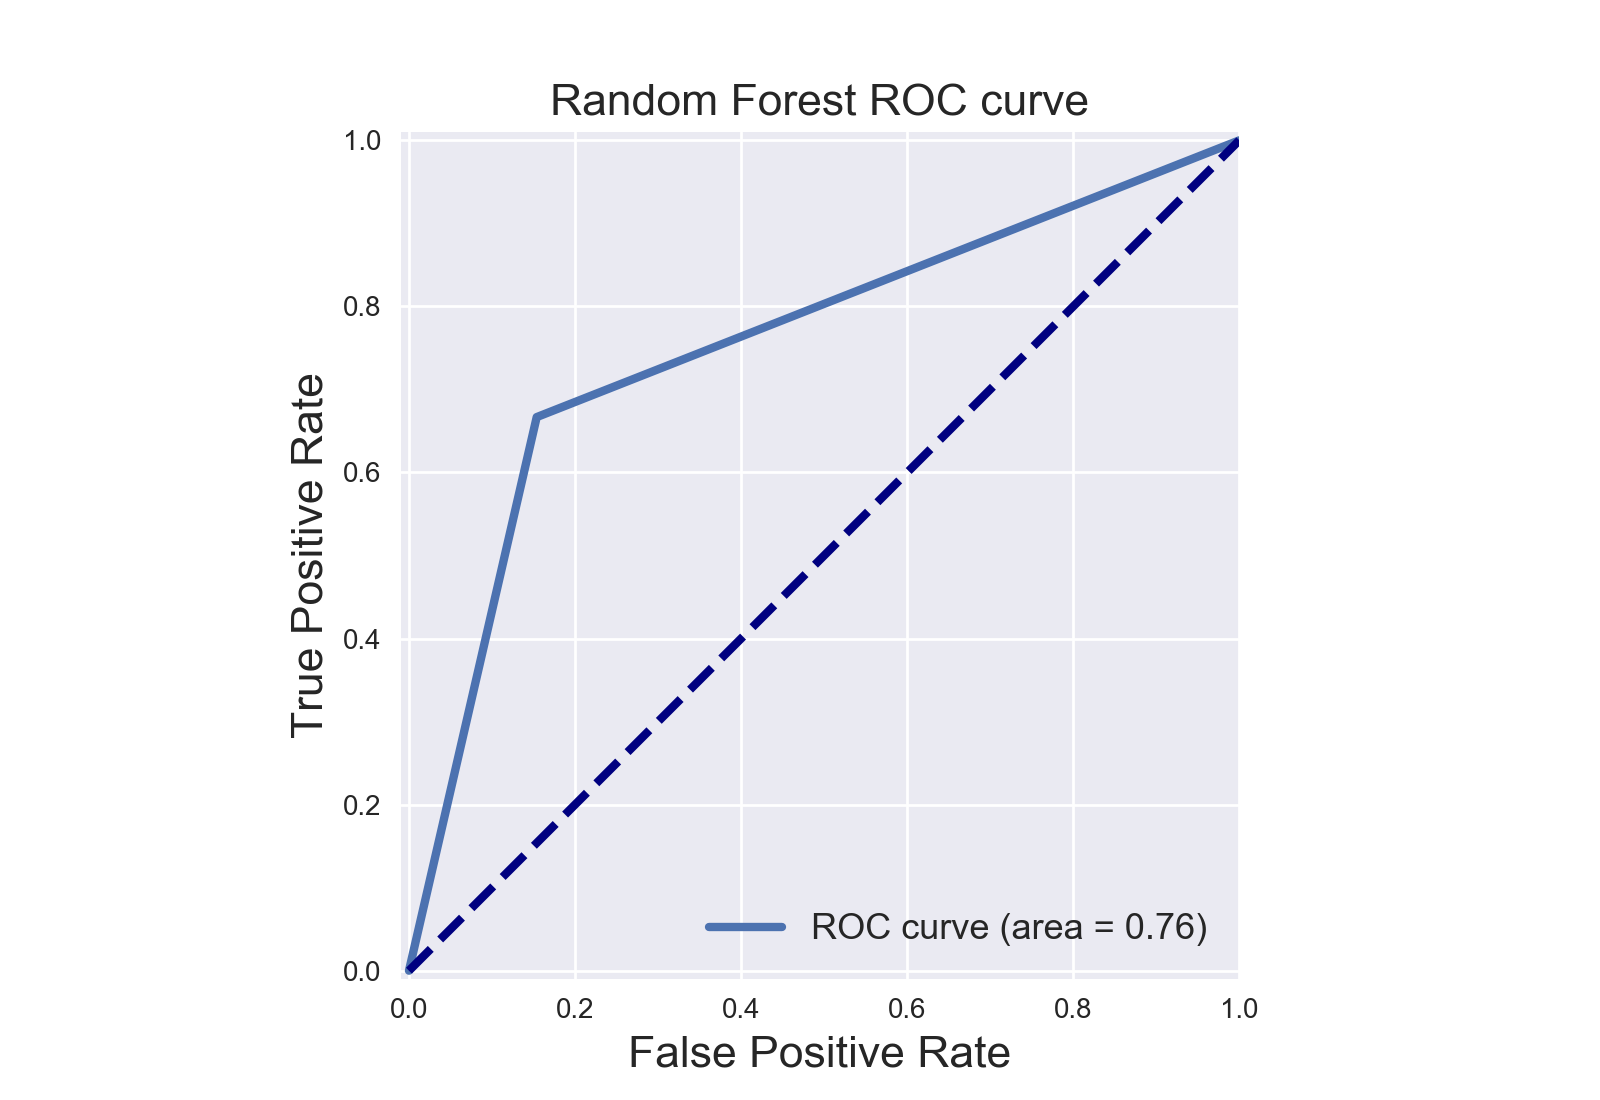

<IPython.core.display.Javascript object>


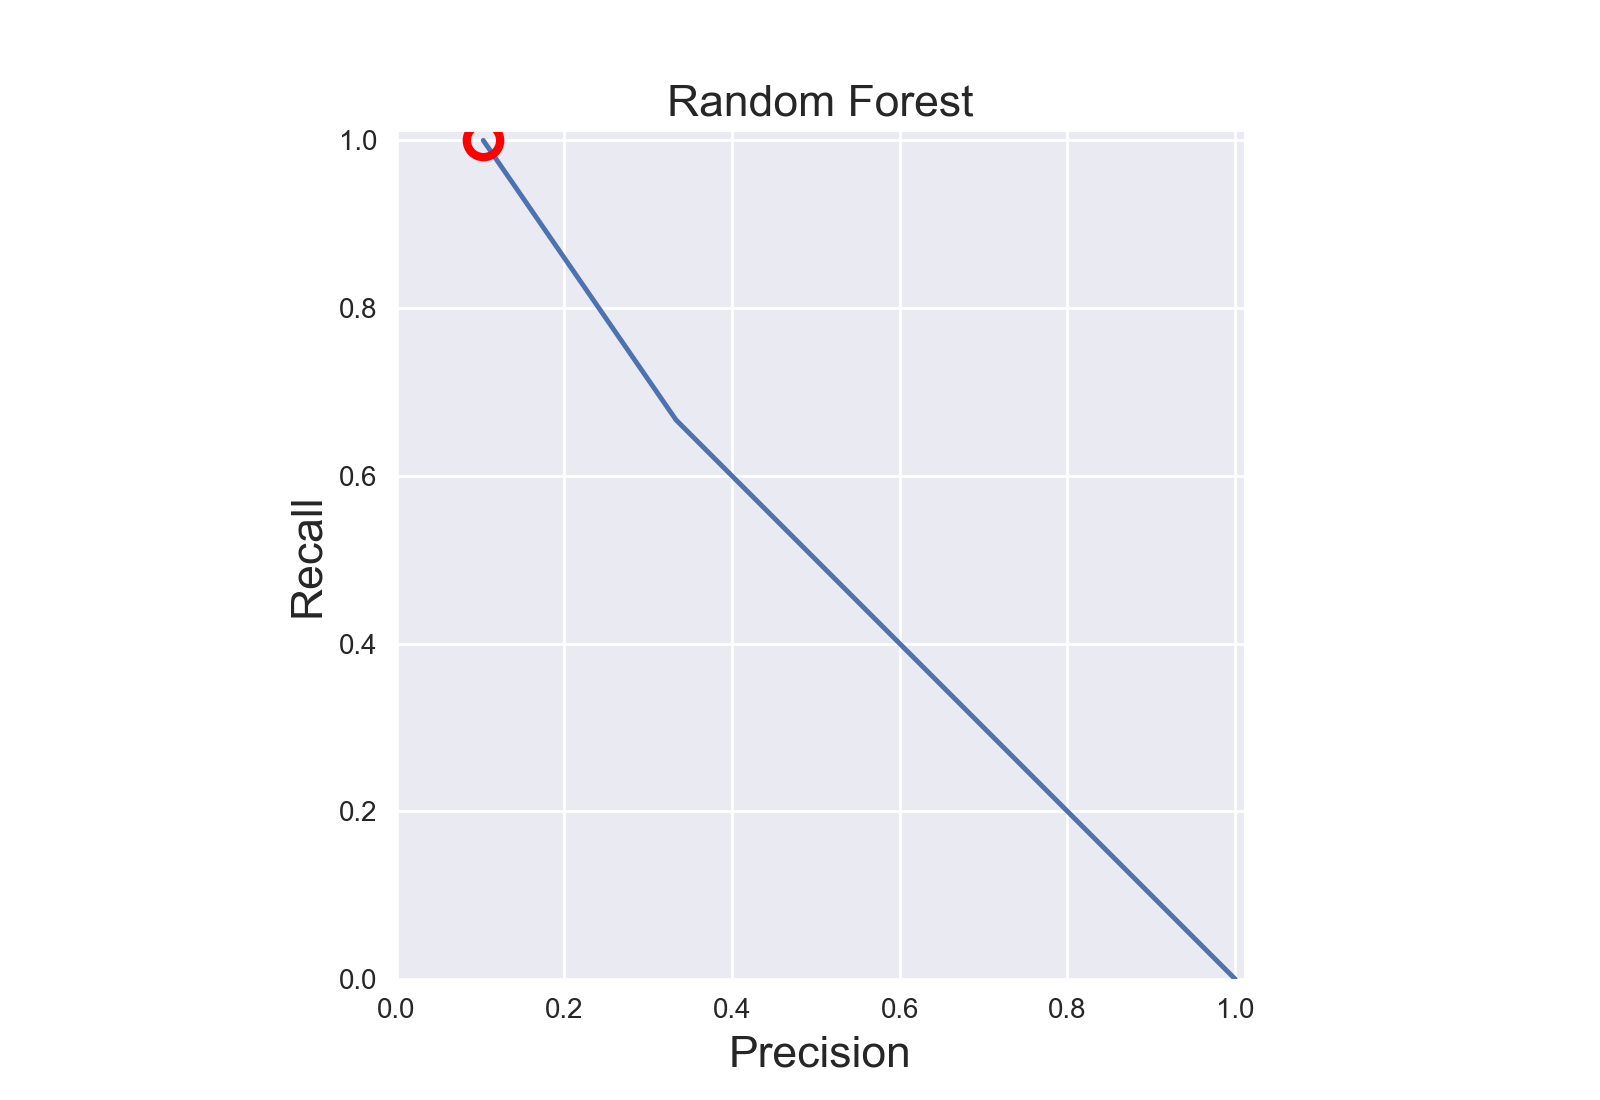

Random Forest 
             precision    recall  f1-score   support

        0.0       0.96      0.85      0.90        26
        1.0       0.33      0.67      0.44         3

avg / total       0.89      0.83      0.85        29



<IPython.core.display.Javascript object>


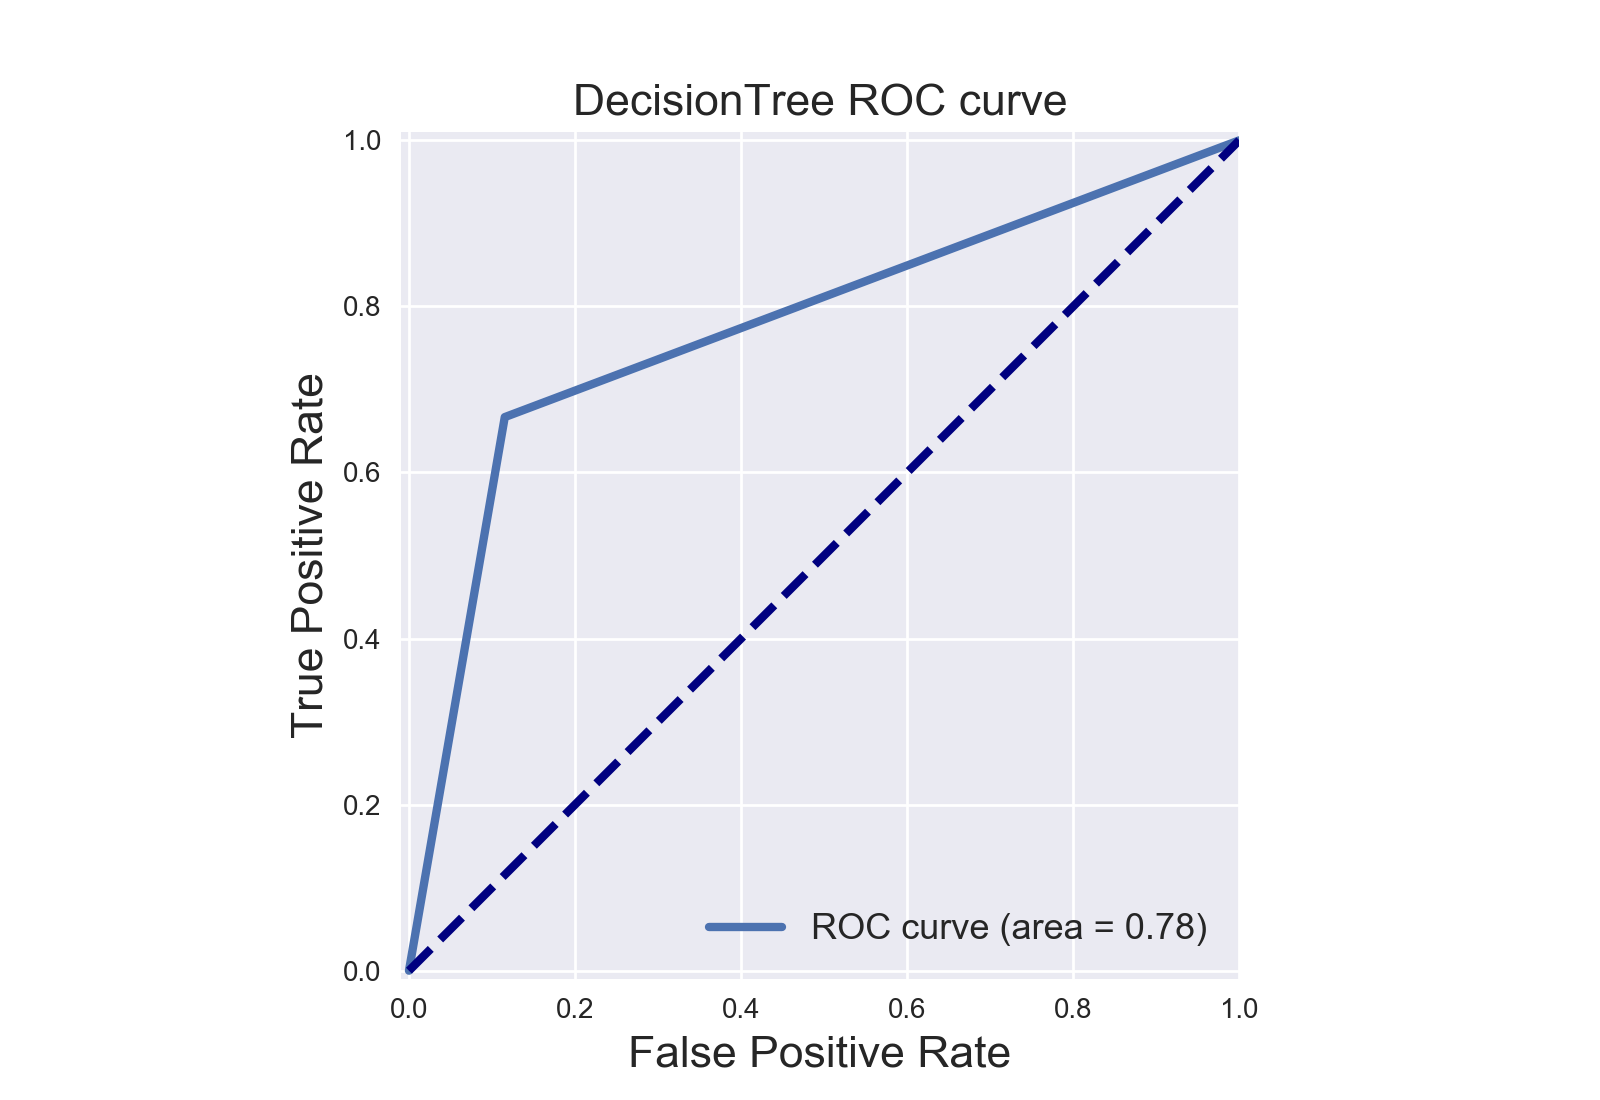

<IPython.core.display.Javascript object>


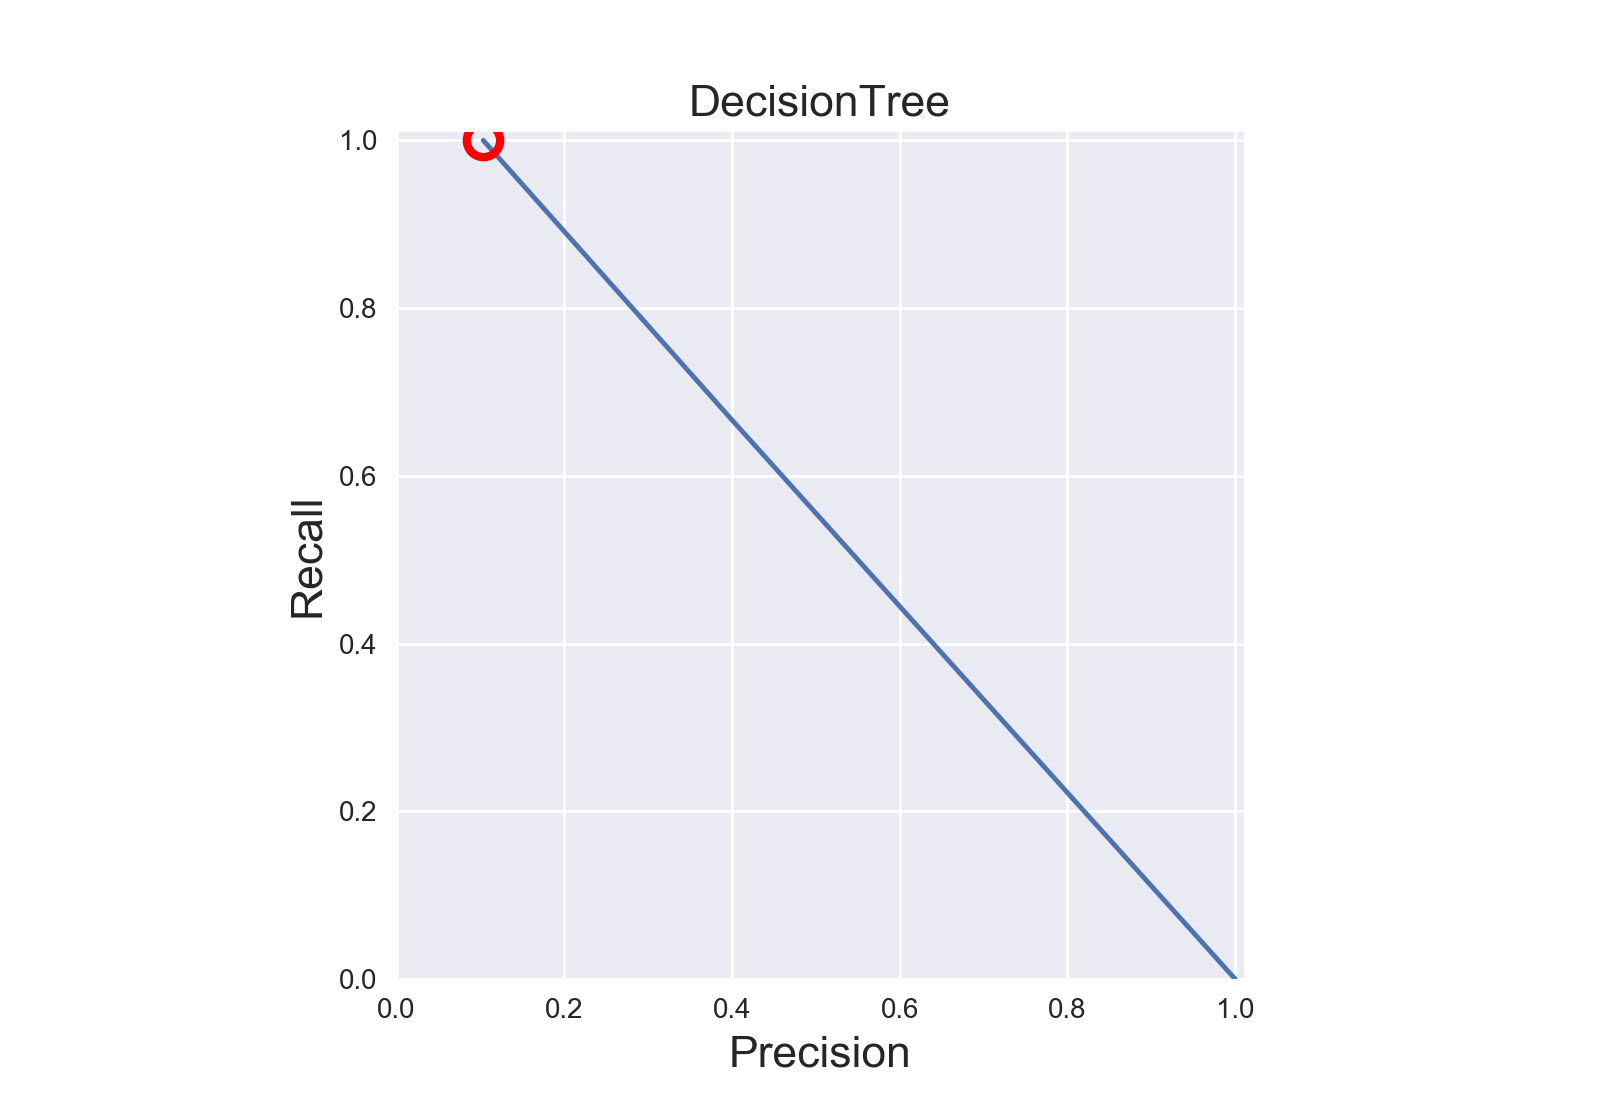

DecisionTree 
             precision    recall  f1-score   support

        0.0       0.96      0.88      0.92        26
        1.0       0.40      0.67      0.50         3

avg / total       0.90      0.86      0.88        29



/Users/Joel/anaconda/envs/py2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<IPython.core.display.Javascript object>


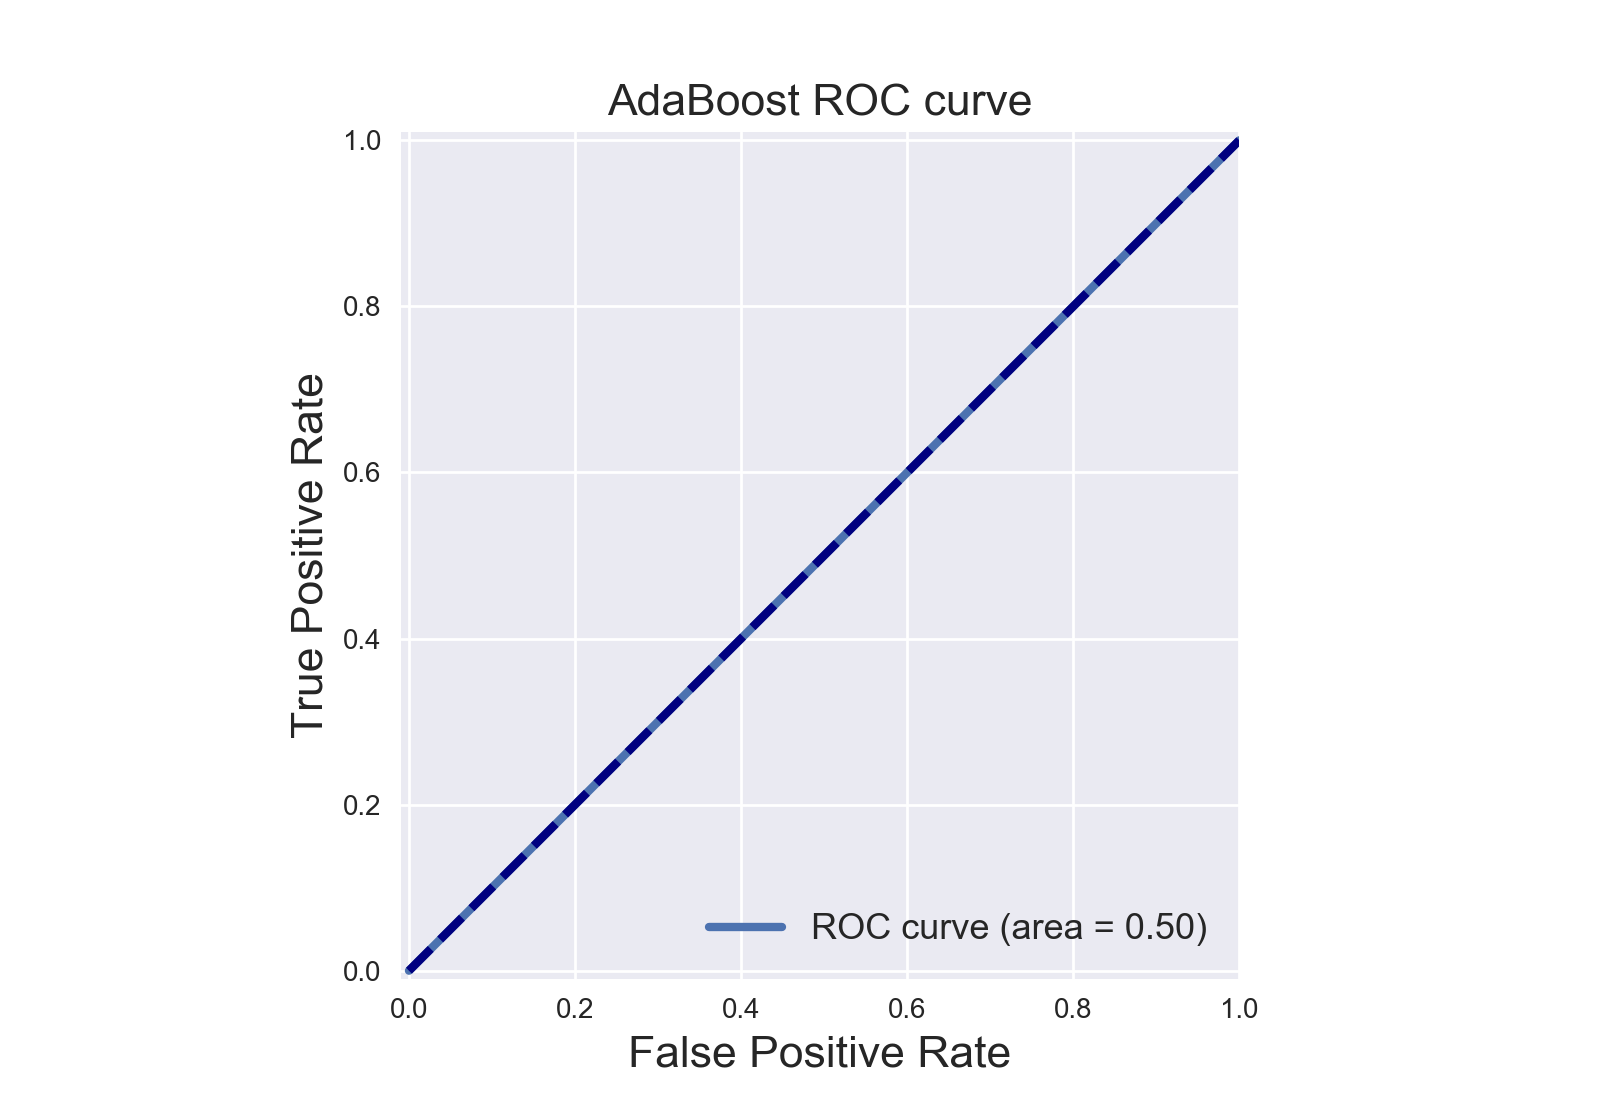

<IPython.core.display.Javascript object>


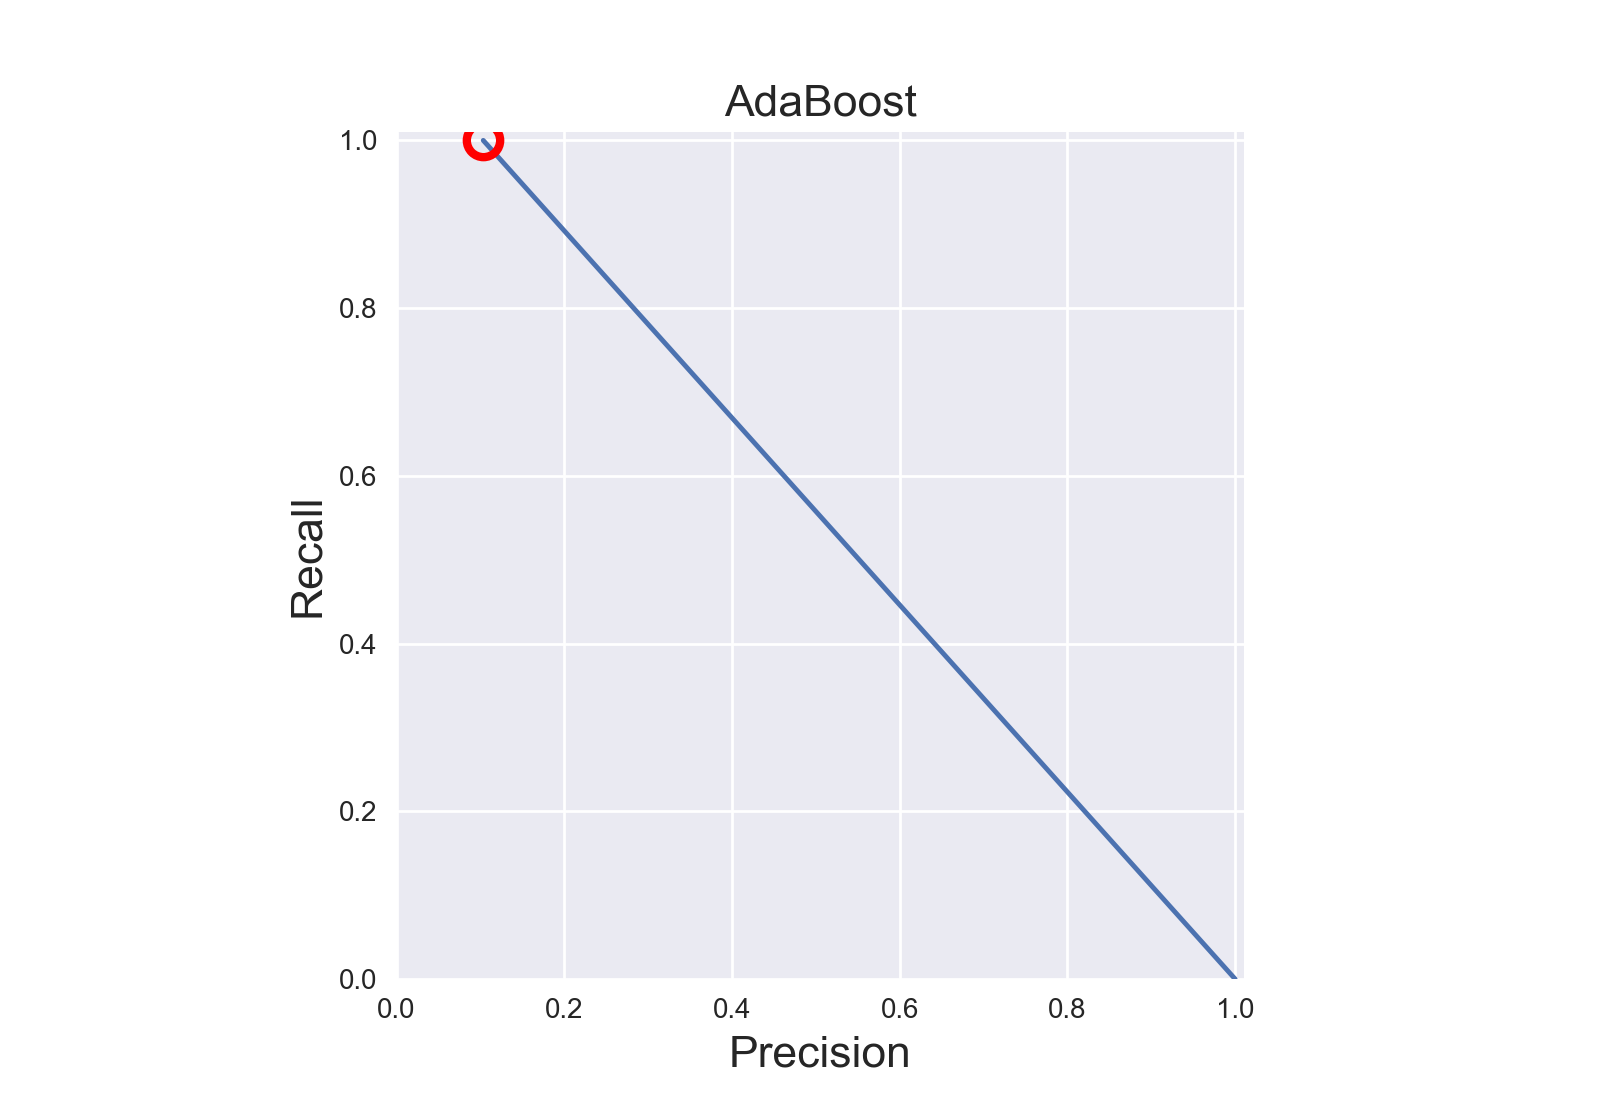

AdaBoost 
             precision    recall  f1-score   support

        0.0       0.90      1.00      0.95        26
        1.0       0.00      0.00      0.00         3

avg / total       0.80      0.90      0.85        29



<IPython.core.display.Javascript object>


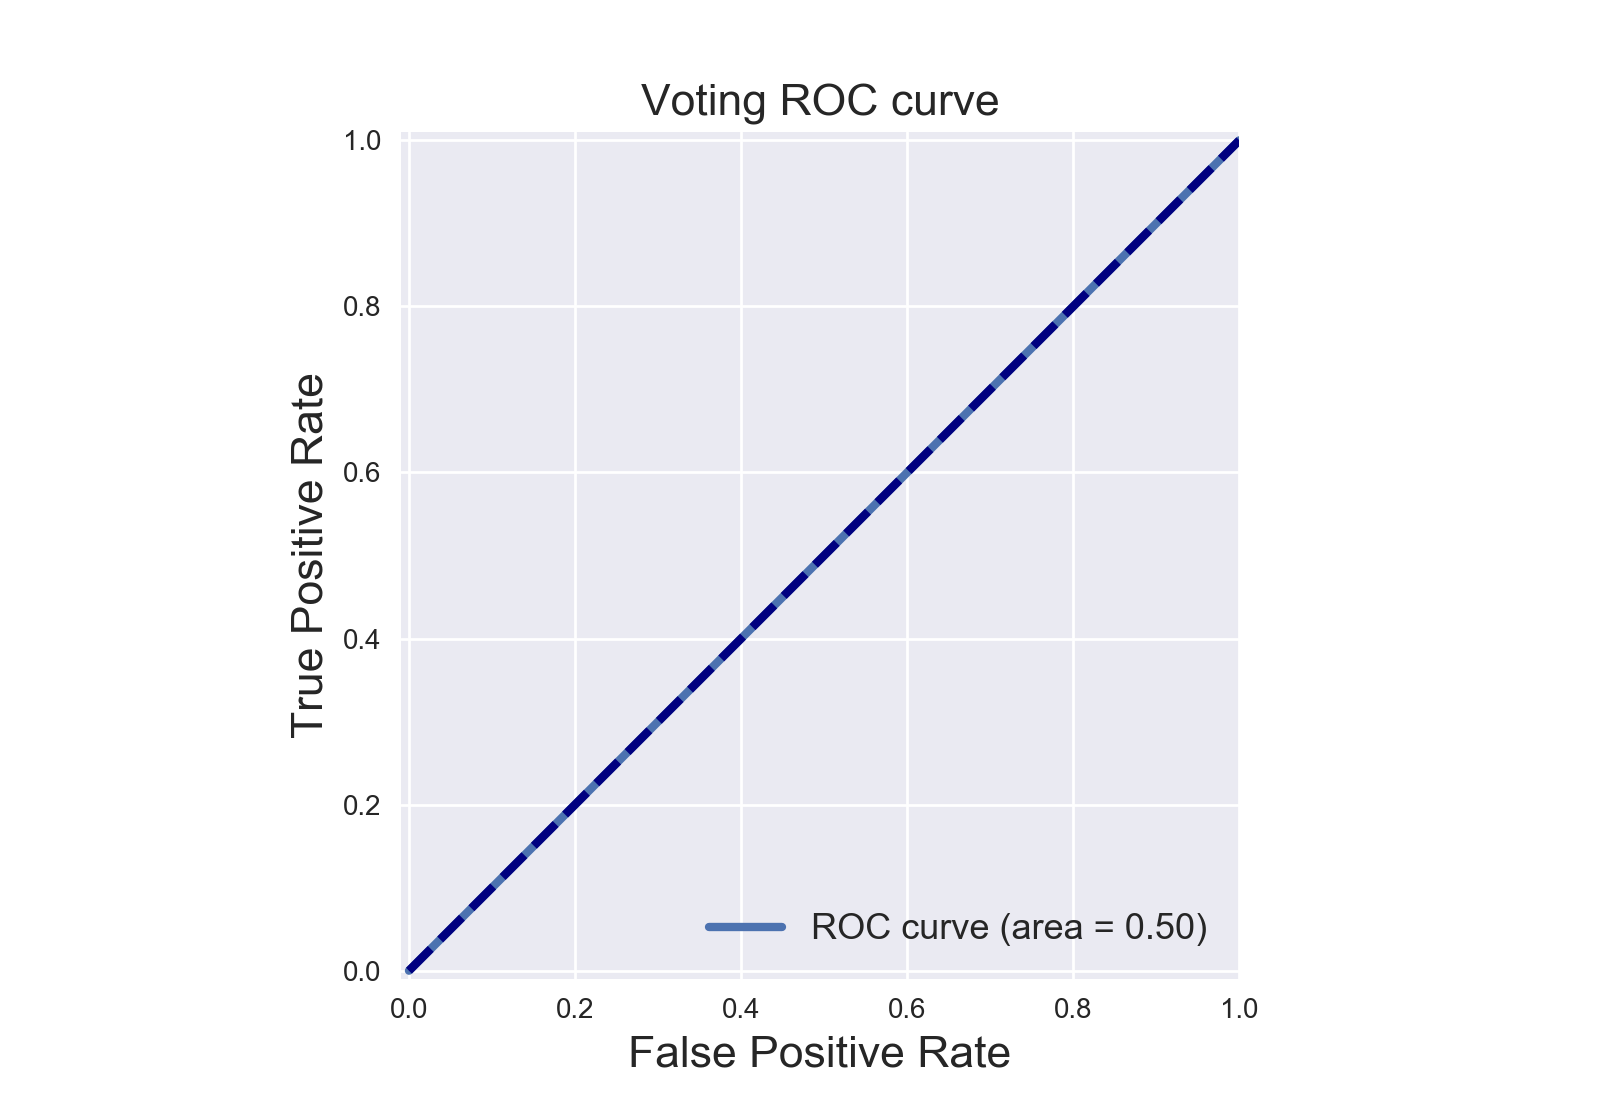

<IPython.core.display.Javascript object>


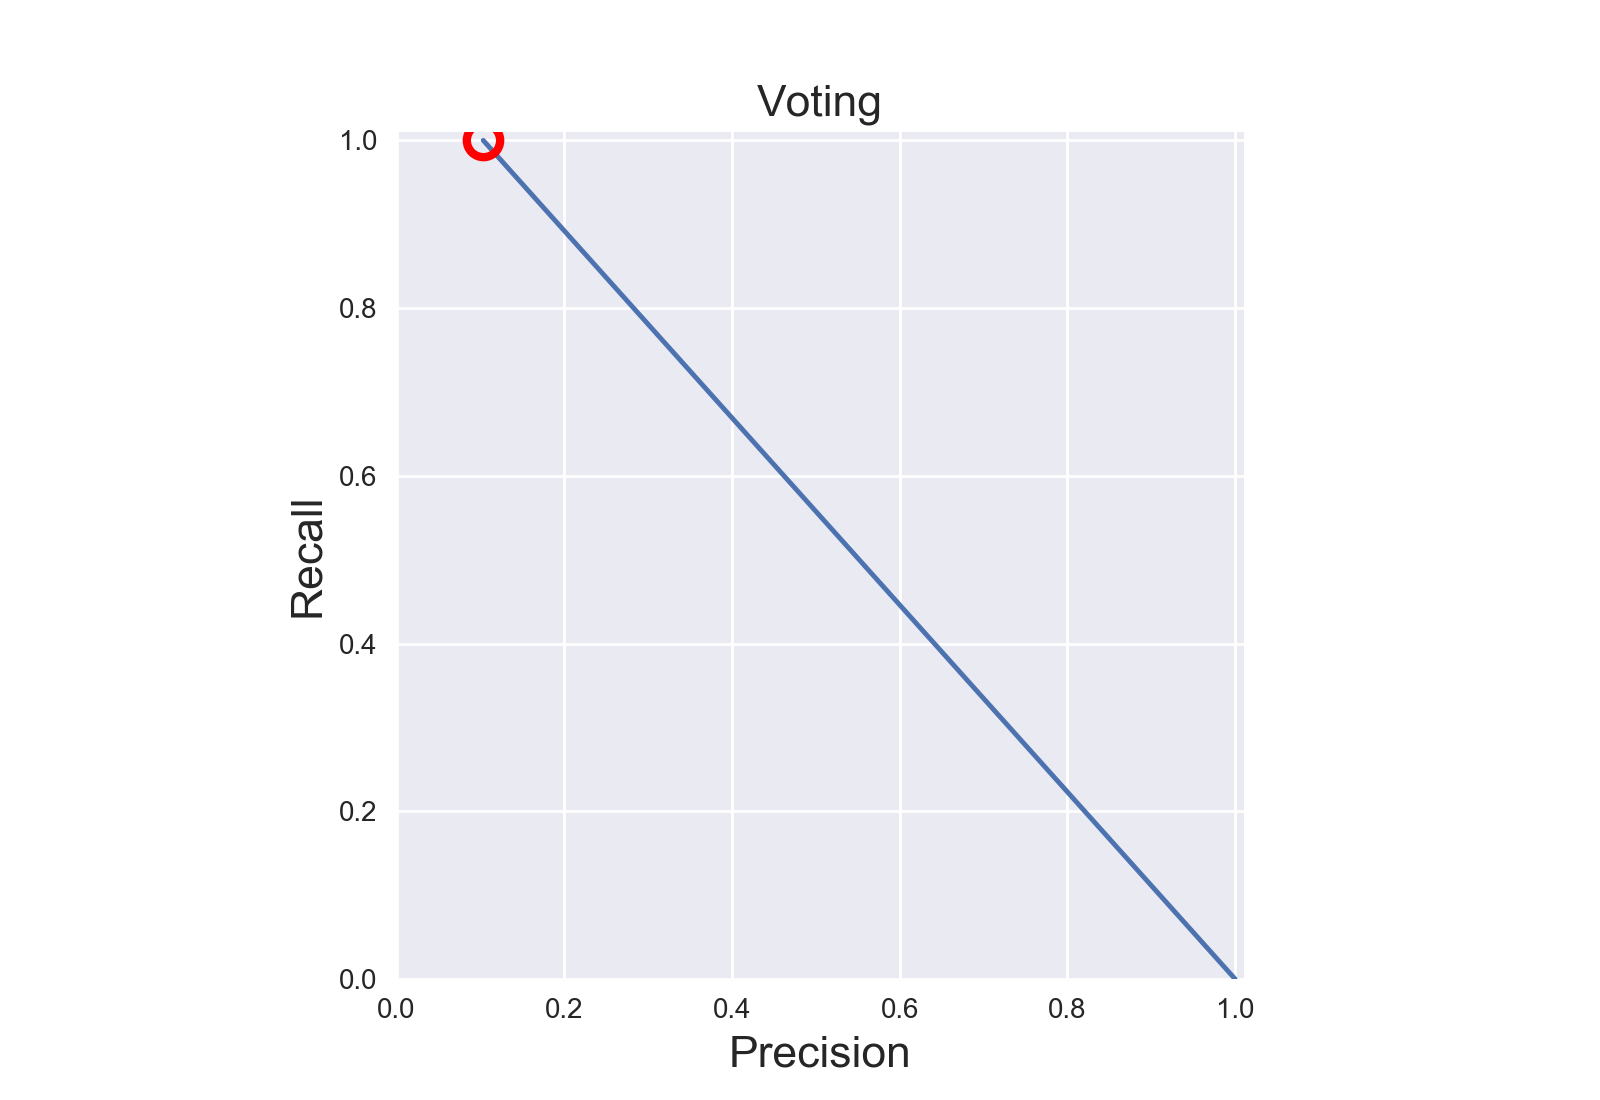

Voting 
             precision    recall  f1-score   support

        0.0       0.90      1.00      0.95        26
        1.0       0.00      0.00      0.00         3

avg / total       0.80      0.90      0.85        29



/Users/Joel/anaconda/envs/py2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


<IPython.core.display.Javascript object>


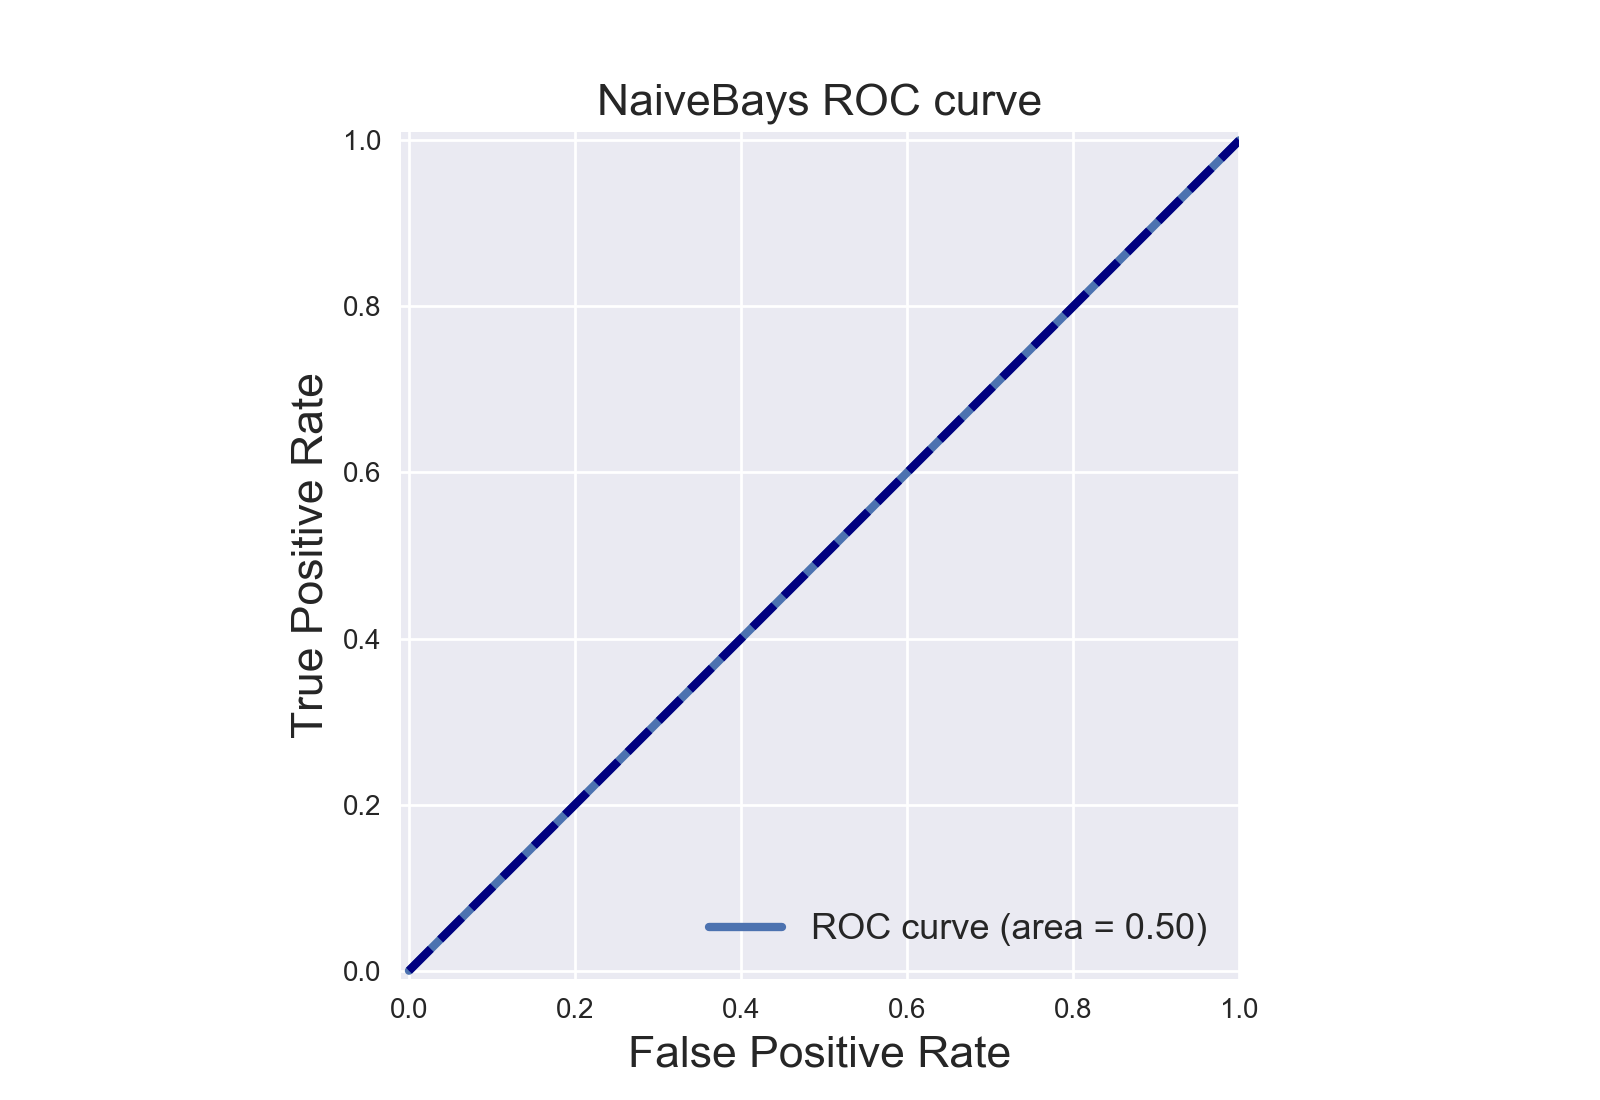

<IPython.core.display.Javascript object>


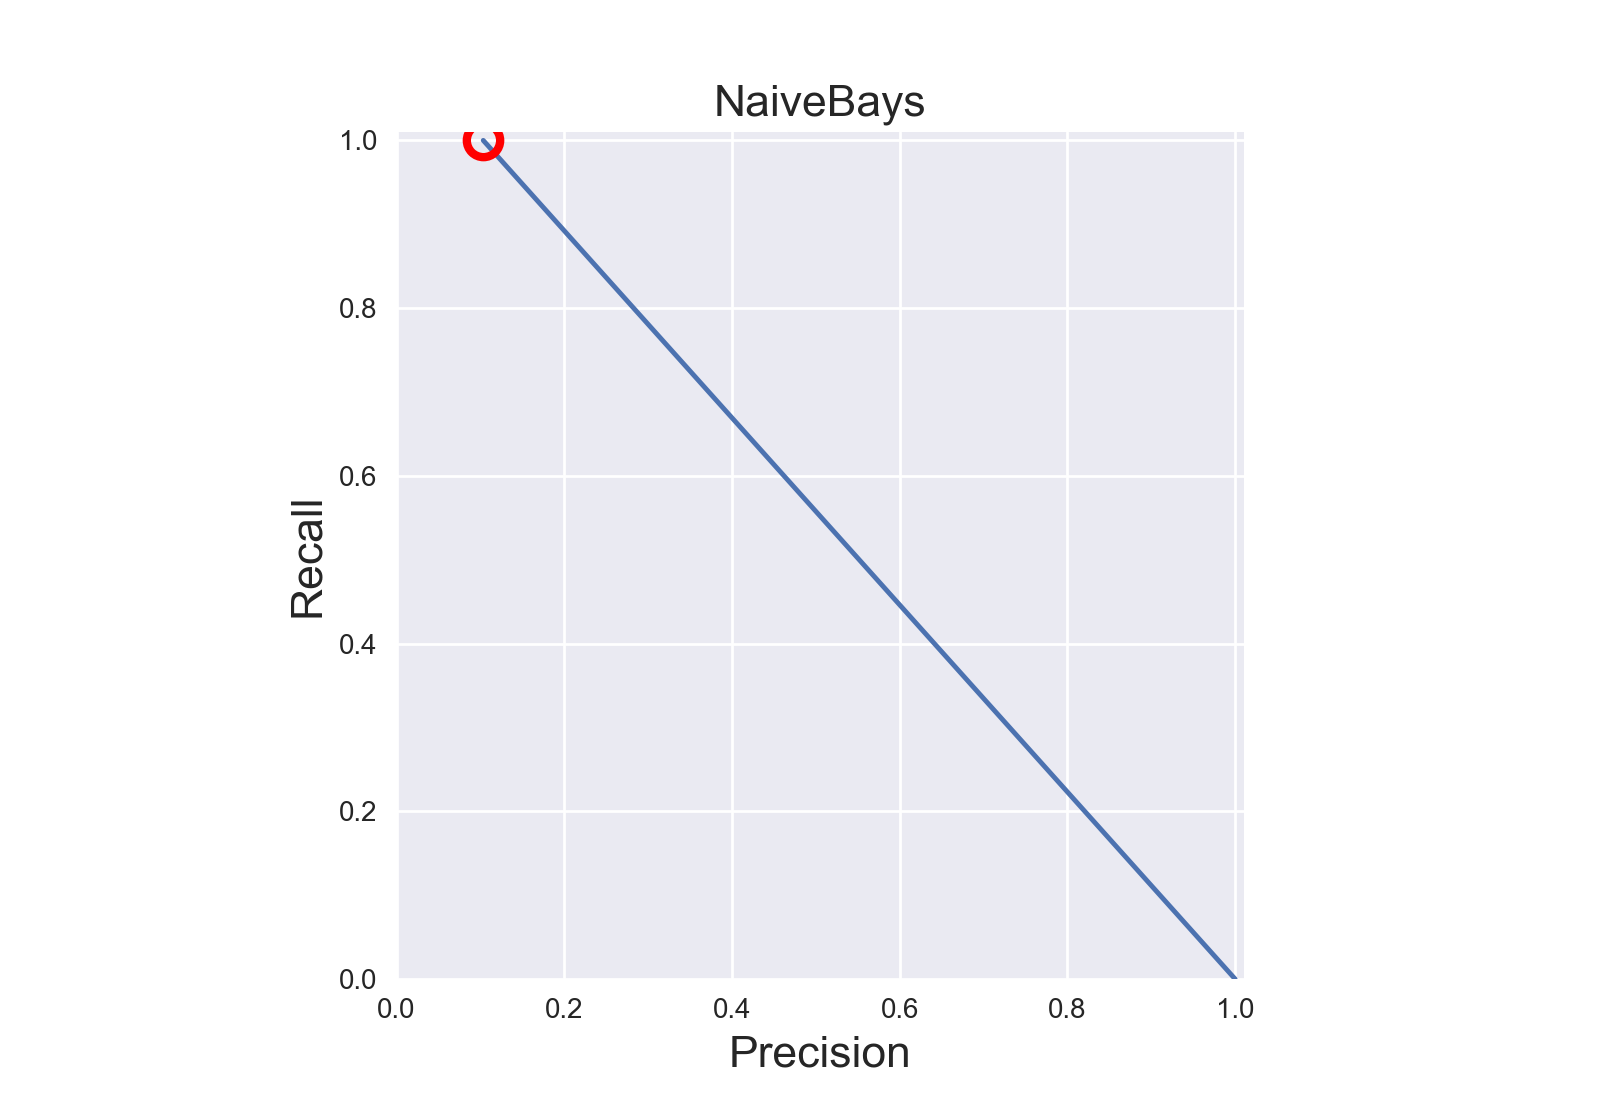

NaiveBays 
             precision    recall  f1-score   support

        0.0       0.90      1.00      0.95        26
        1.0       0.00      0.00      0.00         3

avg / total       0.80      0.90      0.85        29

========Accuracy========
GradientBoost Acc Score: 0.841897+/-(0.045066) TestSet Acc Score:0.827586 
Random Forest Acc Score: 0.832411+/-(0.072907) TestSet Acc Score:0.827586 
DecisionTree Acc Score: 0.841107+/-(0.063211) TestSet Acc Score:0.862069 
AdaBoost Acc Score: 0.789723+/-(0.138225) TestSet Acc Score:0.896552 
Voting Acc Score: 0.850988+/-(0.058674) TestSet Acc Score:0.896552 
NaiveBays Acc Score: 0.437549+/-(0.134953) TestSet Acc Score:0.896552 

========Precision========
GradientBoost Precision Score: 0.183333+/-(0.260342) TestSet Precision Score:0.892054 
Random Forest Precision Score: 0.300000+/-(0.400000) TestSet Precision Score:0.892054 
DecisionTree Precision Score: 0.290000+/-(0.190788) TestSet Precision Score:0.900575 
AdaBoost Precision Score: 0.3

<IPython.core.display.Javascript object>


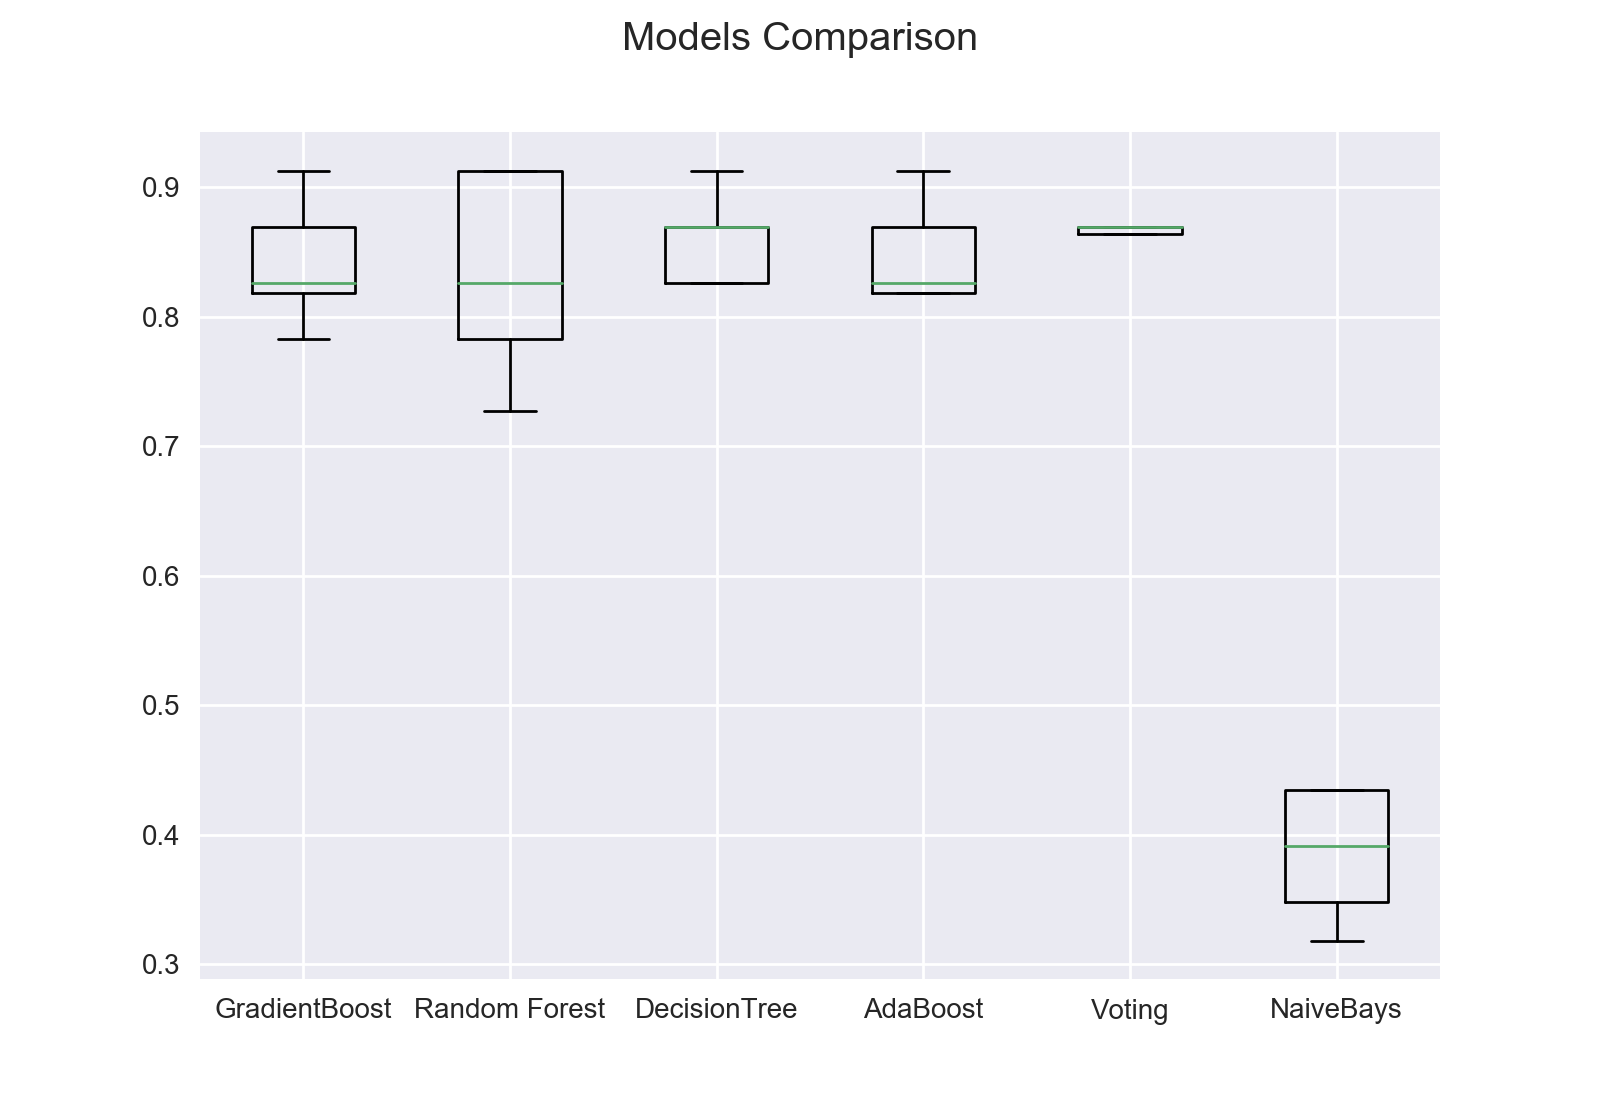

In [97]:
# ensembles
dt_clf = DecisionTreeClassifier()
rf_clf = RandomForestClassifier()
gb_clf = GradientBoostingClassifier()
ensembles = []
ensembles.append(('GradientBoost', gb_clf))
ensembles.append(('Random Forest', rf_clf )) 
ensembles.append(('DecisionTree', dt_clf))
ensembles.append(('AdaBoost', ad_clf))
ensembles.append(('Voting', vot_clf))
ensembles.append(('NaiveBays', nb_clf ))
results = []
names = []
AccScore = []
PrecScore = []
RecallScore = []

for name, model in ensembles:
    kfold = KFold(n_splits=5, shuffle = True, random_state=None)
    ####
    acc_results = cross_val_score(model, Xtrain, ytrain, cv=kfold, scoring='accuracy')
    pre_results = cross_val_score(model, Xtrain, ytrain, cv=kfold, scoring='precision')
    recall_results = cross_val_score(model, Xtrain, ytrain, cv=kfold, scoring='recall')
    ####
    results.append(acc_results)
    names.append(name)
    model.fit(Xtrain,ytrain)
    
    y_pred = model.predict(Xtest)
    
    accscore = accuracy_score(ytest, y_pred)
    prescore = precision_score(ytest, y_pred, average='weighted') 
    recallscore = recall_score(ytest, y_pred, average='weighted')
    
    accmsg = "%s Acc Score: %f+/-(%f) TestSet Acc Score:%f "% (name, acc_results.mean(), acc_results.std(),accscore)
    AccScore.append(accmsg)

    premsg = "%s Precision Score: %f+/-(%f) TestSet Precision Score:%f "% (name, pre_results.mean(), pre_results.std(), prescore)
    PrecScore.append(premsg)
    
    recmsg = "%s Recall Score: %f+/-(%f) TestSet Recall Score:%f "% (name, recall_results.mean(), recall_results.std(), recallscore)
    RecallScore.append(recmsg)
    
    fpr_lr, tpr_lr, _ = roc_curve(ytest, y_pred)
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    plt.figure()
    plt.xlim([-0.01, 1.00])
    plt.ylim([-0.01, 1.01])
    plt.plot(fpr_lr, tpr_lr, lw=3, label='ROC curve (area = {:0.2f})'.format( roc_auc_lr))
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title(name + ' ROC curve', fontsize=16)
    plt.legend(loc='lower right', fontsize=13)
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
    plt.axes().set_aspect('equal')

    
    precision, recall, thresholds = precision_recall_curve(ytest, y_pred)
    closest_zero = np.argmin(np.abs(thresholds))
    closest_zero_p = precision[closest_zero]
    closest_zero_r = recall[closest_zero]

    plt.figure()
    plt.xlim([0.0, 1.01])
    plt.ylim([0.0, 1.01])
    plt.plot(precision, recall, label='Precision-Recall Curve')
    plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
    plt.title(name, fontsize=16)
    plt.xlabel('Precision', fontsize=16)
    plt.ylabel('Recall', fontsize=16)
    plt.axes().set_aspect('equal')
    plt.show()
    print name,'\n',classification_report(ytest, y_pred)
    
print '========Accuracy========'
for i in AccScore:
    print(i)
print '\n','========Precision========'
for i in PrecScore:
    print(i)
print '\n','========Recall========'
for i in RecallScore:
    print(i)
    
fig = plt.figure()
fig.suptitle('Models Comparison') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels(names)
plt.show()


### 参数调整

In [98]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from tester import dump_classifier_and_data, test_classifier
scaler = MinMaxScaler()
kfold = KFold(n_splits=5, shuffle = True,random_state=42)

- DecisionTree Tunning

In [99]:
model = DecisionTreeClassifier()
param_test={'criterion' : ['gini', 'entropy'], 'max_depth':[ 2,3,4] }
Gridsearch = GridSearchCV(estimator = model, param_grid = param_test, scoring='recall', cv=kfold)
scaler.fit_transform(Xtrain)
Gridsearch.fit(Xtrain, ytrain)

print('Best score: {}'.format(Gridsearch.best_score_))
print('Best parameters: {}'.format(Gridsearch.best_params_))
print('Best estimator: {}'.format(Gridsearch.best_estimator_ ))
############################
dt_clf = Gridsearch.best_estimator_ 
############################
y_pred = Gridsearch.best_estimator_ .predict(Xtest)  
print '\n',classification_report(ytest, y_pred)

Best score: 0.369883040936
Best parameters: {'criterion': 'entropy', 'max_depth': 2}
Best estimator: DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

             precision    recall  f1-score   support

        0.0       0.93      1.00      0.96        26
        1.0       1.00      0.33      0.50         3

avg / total       0.94      0.93      0.92        29



- Random Forest Tunning

In [100]:
model = RandomForestClassifier()
param_test={'n_estimators' : [10,20,30], 'max_features':[None],'criterion':['gini','entropy'],'max_depth':[2,3,4,5] }
Gridsearch = GridSearchCV(estimator = model, param_grid = param_test, scoring='recall', cv=kfold)
scaler.fit_transform(Xtrain)
Gridsearch.fit(Xtrain, ytrain)

print('Best score: {}'.format(Gridsearch.best_score_))
print('Best parameters: {}'.format(Gridsearch.best_params_))
print('Best estimator: {}'.format(Gridsearch.best_estimator_ ))
############################
rf_clf = Gridsearch.best_estimator_ 
############################
y_pred = Gridsearch.best_estimator_ .predict(Xtest)  
print '\n',classification_report(ytest, y_pred)

Best score: 0.302631578947
Best parameters: {'max_features': None, 'n_estimators': 20, 'criterion': 'entropy', 'max_depth': 4}
Best estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=4, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

             precision    recall  f1-score   support

        0.0       0.92      0.88      0.90        26
        1.0       0.25      0.33      0.29         3

avg / total       0.85      0.83      0.84        29



- GradientBoos Tunning

In [101]:
model = GradientBoostingClassifier()
param_test={'max_depth':[3,4,5,6],'min_samples_split':[3,4,5],'subsample':[.7,.8,.9]}
Gridsearch = GridSearchCV(estimator = model, param_grid = param_test, scoring='recall', cv=kfold)
scaler.fit_transform(Xtrain)
Gridsearch.fit(Xtrain, ytrain)

print('Best score: {}'.format(Gridsearch.best_score_))
print('Best parameters: {}'.format(Gridsearch.best_params_))
print('Best estimator: {}'.format(Gridsearch.best_estimator_ ))
############################
gb_clf = Gridsearch.best_estimator_ 
############################
y_pred = Gridsearch.best_estimator_ .predict(Xtest)  
print '\n',classification_report(ytest, y_pred)

Best score: 0.437134502924
Best parameters: {'min_samples_split': 3, 'subsample': 0.9, 'max_depth': 3}
Best estimator: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=3, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=0.9, verbose=0, warm_start=False)

             precision    recall  f1-score   support

        0.0       0.96      0.88      0.92        26
        1.0       0.40      0.67      0.50         3

avg / total       0.90      0.86      0.88        29



In [102]:
model = AdaBoostClassifier(base_estimator = GaussianNB())
param_test={'learning_rate':[1,2,3], 'n_estimators':[50,55,60]}
Gridsearch = GridSearchCV(estimator = model, param_grid = param_test, scoring='recall', cv=kfold)
scaler.fit_transform(Xtrain)
Gridsearch.fit(Xtrain, ytrain)

print('Best score: {}'.format(Gridsearch.best_score_))
print('Best parameters: {}'.format(Gridsearch.best_params_))
print('Best estimator: {}'.format(Gridsearch.best_estimator_ ))
############################
ad_clf = Gridsearch.best_estimator_ 
############################
y_pred = Gridsearch.best_estimator_ .predict(Xtest)  
print '\n',classification_report(ytest, y_pred)

Best score: 0.521198830409
Best parameters: {'n_estimators': 55, 'learning_rate': 2}
Best estimator: AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=GaussianNB(priors=None), learning_rate=2,
          n_estimators=55, random_state=None)

             precision    recall  f1-score   support

        0.0       0.89      0.96      0.93        26
        1.0       0.00      0.00      0.00         3

avg / total       0.80      0.86      0.83        29



- Voting Classifier Tunning

In [103]:
model = VotingClassifier(estimators=[('dt', dt_clf), ('rf',rf_clf),('ad', ad_clf),('nb', nb_clf)], voting='soft')
scaler.fit_transform(Xtrain)
model.fit(Xtrain, ytrain)

y_pred = model.predict(Xtest)  
print '\n',classification_report(ytest, y_pred)


             precision    recall  f1-score   support

        0.0       0.90      1.00      0.95        26
        1.0       0.00      0.00      0.00         3

avg / total       0.80      0.90      0.85        29



## 調參後的VotingClassifier 
#### 1. 精準度平均：80%
#### 2. 回召率平均：83%
#### 3. F1-Score 平均：81%

## 特徵工程處理後的數據表現 ＶＳ 未經處理的數據表現


In [114]:
col_new = ['retention_incentives/key_payments','bonus/salary','poi_emailratio',
    'exercised_stock_options/salary','key_payments',
    'retention_incentives','bonus', 'deferral_payments', 'deferred_income', 
    'director_fees', 'exercised_stock_options', 'expenses',
       'from_messages', 'from_poi_to_this_person',
       'from_this_person_to_poi', 'loan_advances', 'long_term_incentive',
       'other', 'restricted_stock', 'restricted_stock_deferred',
       'salary', 'shared_receipt_with_poi', 'to_messages',
       'total_payments', 'total_stock_value']

col = ['bonus', 'deferral_payments', 'deferred_income', 'director_fees',
       'exercised_stock_options', 'expenses',
       'from_messages', 'from_poi_to_this_person',
       'from_this_person_to_poi', 'loan_advances', 'long_term_incentive',
       'other', 'restricted_stock', 'restricted_stock_deferred',
       'salary', 'shared_receipt_with_poi', 'to_messages',
       'total_payments', 'total_stock_value']

### 加入新特徵的表現

In [115]:
X_train, y_train = df[col_new], df.poi.values
Xtrain, Xtest, ytrain, ytest = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)
model = VotingClassifier(estimators=[('dt', dt_clf), ('rf',rf_clf),('ad', ad_clf),('nb', nb_clf)], voting='soft')
model.fit(Xtrain, ytrain)

y_pred = model.predict(Xtest)  
print '\n',classification_report(ytest, y_pred)


             precision    recall  f1-score   support

        0.0       0.96      0.96      0.96        27
        1.0       0.50      0.50      0.50         2

avg / total       0.93      0.93      0.93        29



### 原始特徵的表現

In [116]:
X_train, y_train = df[col], df.poi.values
Xtrain, Xtest, ytrain, ytest = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)
model = VotingClassifier(estimators=[('dt', dt_clf), ('rf',rf_clf),('ad', ad_clf),('nb', nb_clf)], voting='soft')
model.fit(Xtrain, ytrain)

y_pred = model.predict(Xtest)  
print '\n',classification_report(ytest, y_pred)


             precision    recall  f1-score   support

        0.0       0.93      0.93      0.93        27
        1.0       0.00      0.00      0.00         2

avg / total       0.86      0.86      0.86        29



In [46]:
enron_data = {}

for i in df.index:
    enron_attr = {}
    for j in features_list:        
        enron_attr[j] = df.loc[i][j]
    enron_data[i] = enron_attr
enron_data

{'ALLEN PHILLIP K': {'bonus': 4175000.0,
  'deferral_payments': 2869717.0,
  'deferred_income': -3081055.0,
  'director_fees': 0.0,
  'exercised_stock_options': 1729541.0,
  'expenses': 13868.0,
  'extra_payment_std': 10.062711884294258,
  'from_messages': 2195.0,
  'from_poi_to_this_person': 47.0,
  'from_this_person_to_poi': 65.0,
  'ica_1': 0.13376915383936097,
  'ica_2': 0.057705417001888568,
  'ica_3': 0.042402499652098802,
  'ica_4': -0.014503535666925338,
  'kca_1': -0.13418565382889375,
  'kca_2': -0.057185149279721251,
  'kca_3': 0.014546237391032146,
  'kca_4': -0.041772026285308489,
  'loan_advances': 0.0,
  'long_term_incentive': 304805.0,
  'other': 152.0,
  'pca_1': 758581.30501521984,
  'pca_2': -1563781.6585456659,
  'pca_3': 2918085.2005247562,
  'pca_4': 1299085.2809710812,
  'restricted_stock': 126027.0,
  'restricted_stock_deferred': -126027.0,
  'salary': 201955.0,
  'shared_receipt_with_poi': 1407.0,
  'to_messages': 2902.0,
  'total_payments': 4484442.0,
  'total

In [54]:
features_list = list(feat_labels[indices])[:-15]

clf = Gridsearch.best_estimator_  

pickle.dump(clf, open("my_classifier.pkl", "w") )
pickle.dump(enron_data, open("my_dataset.pkl", "w") )
pickle.dump(features_list, open("my_feature_list.pkl", "w") )
